In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from skopt.space import Real, Categorical, Integer
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
from sklearn.svm import LinearSVC, SVC
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
import category_encoders as ce
import warnings
warnings.simplefilter('ignore')
SaveDir =  '../../Data/NewFeatures'
OriginDataDir = '../../Data/OriginData'
CleanDataDir = '../../Data/CleanData'
TrainTestDataDir = '../../Data/TrainTestData'
ModelSaveDir = 'models'
ResultSaveDir = 'result_xgb'
ResultSaveDir_open = 'result_open'

In [2]:
def loadData(Dir, DataName, index_col_flag = False):
    DataPath = os.path.join(Dir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    if index_col_flag:
        OriginData = pd.read_csv(DataPath,index_col=0)
    else:
        OriginData = pd.read_csv(DataPath)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [3]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    #plt.tight_layout()

## 1.加载保存好的数据，并做一些处理

In [6]:
X = loadData('./','df_train_oof.csv',index_col_flag = True)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 142 entries, SK_ID_CURR to xgb9_pred
dtypes: float64(141), int64(1)
memory usage: 335.5 MB


In [8]:
X.head()

,SK_ID_CURR,TARGET,WithCategory_lgbmodel0_pred,WithCategory_lgbmodel1_pred,WithCategory_lgbmodel10_pred,WithCategory_lgbmodel11_pred,WithCategory_lgbmodel12_pred,WithCategory_lgbmodel13_pred,WithCategory_lgbmodel14_pred,WithCategory_lgbmodel15_pred,...,xgb18_pred,xgb19_pred,xgb2_pred,xgb3_pred,xgb4_pred,xgb5_pred,xgb6_pred,xgb7_pred,xgb8_pred,xgb9_pred
0,100002,1.0,0.231973,0.225429,0.265913,0.254450,0.253954,0.216446,0.231242,0.273765,...,0.218072,0.163460,0.306949,0.438685,0.416051,0.245251,0.243865,0.229545,0.200648,0.183082
1,100003,0.0,0.015509,0.013812,0.018322,0.013490,0.018585,0.015945,0.012074,0.012607,...,0.014948,0.015859,0.019579,0.044400,0.038373,0.020704,0.022618,0.017725,0.015483,0.019762
2,100004,0.0,0.032188,0.038566,0.038599,0.040263,0.046181,0.031428,0.038821,0.041542,...,0.030056,0.031891,0.039760,0.089611,0.083794,0.036716,0.038883,0.030704,0.036262,0.029484
3,100006,0.0,0.032332,0.032032,0.030983,0.035523,0.050917,0.041204,0.032079,0.037981,...,0.023182,0.023925,0.046730,0.074339,0.064112,0.030602,0.029732,0.028022,0.025170,0.021094
4,100007,0.0,0.054603,0.065801,0.047002,0.034832,0.058822,0.047725,0.058606,0.053657,...,0.056563,0.050899,0.063277,0.101440,0.084579,0.048319,0.059928,0.055059,0.059462,0.055686


In [9]:
ObjectCol = X.select_dtypes(include=['object']).columns.tolist()
ObjectCol

[]

#### 添加NULL计数

In [8]:
X['NullCount'] = X.isnull().sum(axis=1)

#### Categorical 特征

In [9]:
ceoe = ce.OrdinalEncoder(cols=ObjectCol)

In [10]:
ceoe.fit(X)
X = ceoe.transform(X)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 605 entries, LOAN_RATE to NAME_FAMILY_STATUS
dtypes: float64(581), int64(24)
memory usage: 1.6 GB


In [12]:
X.head()

,LOAN_RATE,EXT_SOURCE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_max,EXT_SOURCE_3over2_NAminus1_Add0.1,CREDIT_INCOME_RATIO,EXT_SOURCE_2over3_NAminus1_Add0.1,BUREAU_DAYS_CREDIT_max,EXT_SOURCE_2over1_NAminus1_Add0.1,EXT_SOURCE_1over3_NAminus1_Add0.1,EMPLOYED_BIRTH_RATIO,...,null_count_2,null_count_3,null_count_cat_3,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,WALLSMATERIAL_MODE,NAME_FAMILY_STATUS
0,0.060749,0.485361,780.0,0.659531,2.007889,1.516229,-103.0,1.982925,0.764643,0.067329,...,43,37,5,100002,1.0,0,0,0,0,0
1,0.027598,0.933513,1216.0,-1.246113,4.790750,-0.802495,-606.0,1.756147,-0.456964,0.070862,...,31,30,4,100003,0.0,1,1,1,1,1
2,0.050000,1.285479,-382.0,1.264753,2.000000,0.790668,-408.0,-0.728791,-1.084904,0.011814,...,91,77,6,100004,0.0,2,0,1,-1,0
3,0.094941,0.650442,NaN,-1.199294,2.316167,-0.833824,NaN,-0.833824,1.000000,0.159905,...,140,131,7,100006,0.0,0,0,0,-1,2
4,0.042623,0.322738,-783.0,-2.128977,4.222222,-0.469709,-1149.0,-0.469709,1.000000,0.152418,...,82,74,6,100007,0.0,3,1,2,-1,0


#### 去掉缺省太多的值

In [13]:
X_null = X.isnull().sum().sort_values(ascending=False)/len(X)

In [14]:
X_null.head(10)

CASH_CARD_RATIO                                                       0.802768
DRAWINGS_RATIO                                                        0.802762
AMT_DRAWINGS_ATM_CURRENT_mean_mean                                    0.797353
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_OWN_CAR_AGE_abs_diff         0.739818
last_180_days_credit_diff_median                                      0.736489
last_180_days_credit_diff_min                                         0.736489
HOUSE_VALUE_sy_2                                                      0.721057
HOUSE_VALUE_sy                                                        0.721057
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_BASEMENTAREA_AVG_abs_diff    0.713980
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_BASEMENTAREA_AVG_diff        0.713980
dtype: float64

In [15]:
X_null_col = list(X_null[X_null == 1].index)
X_null_col

[]

In [16]:
X.drop(X_null_col,axis=1,inplace=True)

In [17]:
X.head()

,LOAN_RATE,EXT_SOURCE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_max,EXT_SOURCE_3over2_NAminus1_Add0.1,CREDIT_INCOME_RATIO,EXT_SOURCE_2over3_NAminus1_Add0.1,BUREAU_DAYS_CREDIT_max,EXT_SOURCE_2over1_NAminus1_Add0.1,EXT_SOURCE_1over3_NAminus1_Add0.1,EMPLOYED_BIRTH_RATIO,...,null_count_2,null_count_3,null_count_cat_3,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,WALLSMATERIAL_MODE,NAME_FAMILY_STATUS
0,0.060749,0.485361,780.0,0.659531,2.007889,1.516229,-103.0,1.982925,0.764643,0.067329,...,43,37,5,100002,1.0,0,0,0,0,0
1,0.027598,0.933513,1216.0,-1.246113,4.790750,-0.802495,-606.0,1.756147,-0.456964,0.070862,...,31,30,4,100003,0.0,1,1,1,1,1
2,0.050000,1.285479,-382.0,1.264753,2.000000,0.790668,-408.0,-0.728791,-1.084904,0.011814,...,91,77,6,100004,0.0,2,0,1,-1,0
3,0.094941,0.650442,NaN,-1.199294,2.316167,-0.833824,NaN,-0.833824,1.000000,0.159905,...,140,131,7,100006,0.0,0,0,0,-1,2
4,0.042623,0.322738,-783.0,-2.128977,4.222222,-0.469709,-1149.0,-0.469709,1.000000,0.152418,...,82,74,6,100007,0.0,3,1,2,-1,0


#### 是否将缺省值变成onehot

In [18]:
for catname in ObjectCol:
    X = pd.concat([X,pd.get_dummies(X[catname],prefix=catname)],axis=1)
    X.drop(catname,inplace=True,axis=1)
X.head()

,LOAN_RATE,EXT_SOURCE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_max,EXT_SOURCE_3over2_NAminus1_Add0.1,CREDIT_INCOME_RATIO,EXT_SOURCE_2over3_NAminus1_Add0.1,BUREAU_DAYS_CREDIT_max,EXT_SOURCE_2over1_NAminus1_Add0.1,EXT_SOURCE_1over3_NAminus1_Add0.1,EMPLOYED_BIRTH_RATIO,...,WALLSMATERIAL_MODE_4,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,NAME_FAMILY_STATUS_0,NAME_FAMILY_STATUS_1,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3,NAME_FAMILY_STATUS_4,NAME_FAMILY_STATUS_5
0,0.060749,0.485361,780.0,0.659531,2.007889,1.516229,-103.0,1.982925,0.764643,0.067329,...,0,0,0,0,1,0,0,0,0,0
1,0.027598,0.933513,1216.0,-1.246113,4.790750,-0.802495,-606.0,1.756147,-0.456964,0.070862,...,0,0,0,0,0,1,0,0,0,0
2,0.050000,1.285479,-382.0,1.264753,2.000000,0.790668,-408.0,-0.728791,-1.084904,0.011814,...,0,0,0,0,1,0,0,0,0,0
3,0.094941,0.650442,NaN,-1.199294,2.316167,-0.833824,NaN,-0.833824,1.000000,0.159905,...,0,0,0,0,0,0,1,0,0,0
4,0.042623,0.322738,-783.0,-2.128977,4.222222,-0.469709,-1149.0,-0.469709,1.000000,0.152418,...,0,0,0,0,1,0,0,0,0,0


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 698 entries, LOAN_RATE to NAME_FAMILY_STATUS_5
dtypes: float64(581), int64(19), uint8(98)
memory usage: 1.6 GB


### 添加新的特征:IsInPreApplication.csv

In [20]:
IsInPreApplication = loadData(SaveDir,'IsInPreApplication.csv',True)
IsInPreApplication.head()

,SK_ID_CURR,TARGET,bureau_nullcount_min,bureau_nullcount_mean,bureau_nullcount_max,bureau_nullcount_std,isinbureau,POS_CASH_nullcount_min,POS_CASH_nullcount_mean,POS_CASH_nullcount_max,POS_CASH_nullcount_std,isinPOS_CASH,preapp_nullcount_min,preapp_nullcount_mean,preapp_nullcount_max,preapp_nullcount_std,isinpreapp
0,100002,1.0,0.0,1.875,4.0,1.356203,1,0.0,0.000000,0.0,0.000000,1,5.0,5.000000,5.0,0.000000,1
1,100003,0.0,1.0,1.250,2.0,0.500000,1,0.0,0.000000,0.0,0.000000,1,3.0,4.666667,8.0,2.886751,1
2,100004,0.0,1.0,1.500,2.0,0.707107,1,0.0,0.000000,0.0,0.000000,1,3.0,3.000000,3.0,0.000000,1
3,100006,0.0,NaN,NaN,NaN,NaN,0,0.0,0.095238,2.0,0.436436,1,3.0,12.444444,21.0,7.073032,1
4,100007,0.0,1.0,1.000,1.0,0.000000,1,0.0,0.000000,0.0,0.000000,1,3.0,6.833333,13.0,3.763863,1


In [21]:
IsInPreApplication.head()

,SK_ID_CURR,TARGET,bureau_nullcount_min,bureau_nullcount_mean,bureau_nullcount_max,bureau_nullcount_std,isinbureau,POS_CASH_nullcount_min,POS_CASH_nullcount_mean,POS_CASH_nullcount_max,POS_CASH_nullcount_std,isinPOS_CASH,preapp_nullcount_min,preapp_nullcount_mean,preapp_nullcount_max,preapp_nullcount_std,isinpreapp
0,100002,1.0,0.0,1.875,4.0,1.356203,1,0.0,0.000000,0.0,0.000000,1,5.0,5.000000,5.0,0.000000,1
1,100003,0.0,1.0,1.250,2.0,0.500000,1,0.0,0.000000,0.0,0.000000,1,3.0,4.666667,8.0,2.886751,1
2,100004,0.0,1.0,1.500,2.0,0.707107,1,0.0,0.000000,0.0,0.000000,1,3.0,3.000000,3.0,0.000000,1
3,100006,0.0,NaN,NaN,NaN,NaN,0,0.0,0.095238,2.0,0.436436,1,3.0,12.444444,21.0,7.073032,1
4,100007,0.0,1.0,1.000,1.0,0.000000,1,0.0,0.000000,0.0,0.000000,1,3.0,6.833333,13.0,3.763863,1


In [22]:
IsInPreApplication.drop(['SK_ID_CURR','TARGET'],axis=1,inplace=True)

In [23]:
X = pd.concat([X,IsInPreApplication],axis=1)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,POS_CASH_nullcount_min,POS_CASH_nullcount_mean,POS_CASH_nullcount_max,POS_CASH_nullcount_std,isinPOS_CASH,preapp_nullcount_min,preapp_nullcount_mean,preapp_nullcount_max,preapp_nullcount_std,isinpreapp
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.000000,1,5.0,5.000000,5.0,0.000000,1
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,1,3.0,4.666667,8.0,2.886751,1
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,1,3.0,3.000000,3.0,0.000000,1
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.095238,2.0,0.436436,1,3.0,12.444444,21.0,7.073032,1
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,1,3.0,6.833333,13.0,3.763863,1


### 添加新的特征:MyTrainMissingCount.csv

In [24]:
MyTrainMissingCount = loadData(SaveDir,'MyTrainMissingCount.csv',True)
MyTrainMissingCount.head()

,SK_ID_CURR,MissingValueCount,MissingValueCount_cate,TARGET
0,100002,253,3,1.0
1,100003,281,3,0.0
2,100004,355,3,0.0
3,100006,385,3,0.0
4,100007,357,3,0.0


In [25]:
MyTrainMissingCount.drop(['SK_ID_CURR','TARGET'],axis=1,inplace=True)

In [26]:
MyTrainMissingCount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Data columns (total 2 columns):
MissingValueCount         356255 non-null int64
MissingValueCount_cate    356255 non-null int64
dtypes: int64(2)
memory usage: 8.2 MB


In [27]:
MyTrainMissingCount = pd.concat([MyTrainMissingCount,pd.get_dummies(\
                                                                    MyTrainMissingCount['MissingValueCount_cate'],prefix='MissingValueCount_cate')],axis=1)
MyTrainMissingCount.drop('MissingValueCount_cate',inplace=True,axis=1)
MyTrainMissingCount.head()

,MissingValueCount,MissingValueCount_cate_0,MissingValueCount_cate_1,MissingValueCount_cate_2,MissingValueCount_cate_3,MissingValueCount_cate_4,MissingValueCount_cate_5,MissingValueCount_cate_6,MissingValueCount_cate_7,MissingValueCount_cate_8,MissingValueCount_cate_9
0,253,0,0,0,1,0,0,0,0,0,0
1,281,0,0,0,1,0,0,0,0,0,0
2,355,0,0,0,1,0,0,0,0,0,0
3,385,0,0,0,1,0,0,0,0,0,0
4,357,0,0,0,1,0,0,0,0,0,0


In [28]:
X = pd.concat([X,MyTrainMissingCount],axis=1)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MissingValueCount_cate_0,MissingValueCount_cate_1,MissingValueCount_cate_2,MissingValueCount_cate_3,MissingValueCount_cate_4,MissingValueCount_cate_5,MissingValueCount_cate_6,MissingValueCount_cate_7,MissingValueCount_cate_8,MissingValueCount_cate_9
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


### 添加新的特征:NumericIntervalCount.csv

In [29]:
NumericIntervalCount = loadData(SaveDir,'NumericIntervalCount.csv',True)
NumericIntervalCount.head()

,Iter0,Iter1,Iter2,Iter3,Iter4,Iter5,Iter6,Iter7,Iter8,Iter9,Iter10,SK_ID_CURR,TARGET
0,253,419,54,52,59,74,69,49,47,60,65.0,100002,1.0
1,281,27,33,55,79,73,102,376,74,48,53.0,100003,0.0
2,355,97,74,67,54,58,67,323,47,30,29.0,100004,0.0
3,385,145,32,30,56,48,60,250,68,75,52.0,100006,0.0
4,357,22,64,58,52,40,87,364,74,57,26.0,100007,0.0


In [30]:
NumericIntervalCount.drop(['SK_ID_CURR','TARGET'],axis=1,inplace=True)

In [31]:
NumericIntervalCount.fillna(NumericIntervalCount.mean(),inplace=True)

In [32]:
poly = PolynomialFeatures(2)
NumericIntervalCount_np = poly.fit_transform(NumericIntervalCount)

In [33]:
NumericIntervalCount_np.shape

(356255, 78)

In [34]:
NumFeats = pd.DataFrame(columns=['NumFeats%d'%i for i in range(NumericIntervalCount_np.shape[1])], data=NumericIntervalCount_np)

In [35]:
NumFeats.head()
NumFeats.drop('NumFeats0',inplace=True,axis=1)

In [36]:
NumFeats.head()

,NumFeats1,NumFeats2,NumFeats3,NumFeats4,NumFeats5,NumFeats6,NumFeats7,NumFeats8,NumFeats9,NumFeats10,...,NumFeats68,NumFeats69,NumFeats70,NumFeats71,NumFeats72,NumFeats73,NumFeats74,NumFeats75,NumFeats76,NumFeats77
0,253.0,419.0,54.0,52.0,59.0,74.0,69.0,49.0,47.0,60.0,...,2401.0,2303.0,2940.0,3185.0,2209.0,2820.0,3055.0,3600.0,3900.0,4225.0
1,281.0,27.0,33.0,55.0,79.0,73.0,102.0,376.0,74.0,48.0,...,141376.0,27824.0,18048.0,19928.0,5476.0,3552.0,3922.0,2304.0,2544.0,2809.0
2,355.0,97.0,74.0,67.0,54.0,58.0,67.0,323.0,47.0,30.0,...,104329.0,15181.0,9690.0,9367.0,2209.0,1410.0,1363.0,900.0,870.0,841.0
3,385.0,145.0,32.0,30.0,56.0,48.0,60.0,250.0,68.0,75.0,...,62500.0,17000.0,18750.0,13000.0,4624.0,5100.0,3536.0,5625.0,3900.0,2704.0
4,357.0,22.0,64.0,58.0,52.0,40.0,87.0,364.0,74.0,57.0,...,132496.0,26936.0,20748.0,9464.0,5476.0,4218.0,1924.0,3249.0,1482.0,676.0


In [37]:
X = pd.concat([X,NumFeats],axis=1)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,NumFeats68,NumFeats69,NumFeats70,NumFeats71,NumFeats72,NumFeats73,NumFeats74,NumFeats75,NumFeats76,NumFeats77
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2401.0,2303.0,2940.0,3185.0,2209.0,2820.0,3055.0,3600.0,3900.0,4225.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,141376.0,27824.0,18048.0,19928.0,5476.0,3552.0,3922.0,2304.0,2544.0,2809.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,104329.0,15181.0,9690.0,9367.0,2209.0,1410.0,1363.0,900.0,870.0,841.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,62500.0,17000.0,18750.0,13000.0,4624.0,5100.0,3536.0,5625.0,3900.0,2704.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132496.0,26936.0,20748.0,9464.0,5476.0,4218.0,1924.0,3249.0,1482.0,676.0


### 添加新特征：MyTrain

In [38]:
X_mytrain = loadData(CleanDataDir,'MyTrain.csv',index_col_flag = False)

In [39]:
X_mytrain.head()

,100_period_trend_instalment_paid_late_in_days,100_period_trend_instalment_paid_over_amount,10_period_trend_instalment_paid_late_in_days,10_period_trend_instalment_paid_over_amount,12_period_trend_SK_DPD,12_period_trend_SK_DPD_DEF,180_period_trend_days_credit_diff,1_period_trend_SK_DPD,1_period_trend_SK_DPD_DEF,30_period_trend_SK_DPD,...,last_10_instalment_paid_late_in_days_skew_x,NAME_FAMILY_STATUS_CODE_GENDER_mean_DAYS_BIRTH_abs_diff,last_20_instalment_paid_late_in_days_kurt_y,NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_mean_AMT_INCOME_TOTAL_abs_diff,last_5by20_fraction_instalment_paid_late_in_days_skew,last_5by20_fraction_instalment_paid_late_in_days_kurt,last_5_instalment_paid_late_in_days_max_y,NAME_FAMILY_STATUS_CODE_GENDER_mean_REGION_POPULATION_RELATIVE_abs_diff,NAME_EDUCATION_TYPE_CODE_GENDER_max_AMT_ANNUITY_abs_diff,last_5_instalment_paid_late_in_days_skew_x
0,-0.568421,0.000000,0.012121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.413127,2972.362433,-0.474798,48118.423977,2.607188,1.467762,-12.0,0.002460,152995.5,-0.793502
1,-0.085385,0.000000,-0.193939,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,-0.644795,450.277916,-0.686793,58090.823702,1.537067,0.937590,-3.0,0.017104,194463.0,-0.961016
2,-4.000000,0.000000,-4.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.528005,6612.637567,-1.500000,86881.576023,1.000000,1.000000,-3.0,0.011229,170946.0,0.528005
3,-3.588235,0.000000,-0.787879,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,-1.570488,3664.948158,0.729164,22719.615717,0.786713,-0.457936,-1.0,0.012803,186903.0,-1.150049
4,0.114560,-10.699939,-0.400000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,7498.637567,2.414040,32881.576023,-0.000000,-0.724926,0.0,0.007402,155830.5,0.000000


In [40]:
AddFeats = list(set(X_mytrain.columns.tolist())-set(X.columns.tolist()))
len(AddFeats)

940

In [41]:
X = pd.concat([X,X_mytrain[AddFeats]],axis=1)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,NAME_CASH_LOAN_PURPOSE_Car repairs_sum,NEW_CREDIT_TO_ANNUITY_RATIO,AMT_GOODS_PRICE_mean,AMT_INST_MIN_REGULARITY_max_mean,last_1_pos_cash_paid_late_with_tolerance_mean,MONTHS_BALANCE_min_max,AMT_DRAWINGS_ATM_CURRENT_min_max,INSTAL_AMT_PAYMENT_SUM,NAME_GOODS_CATEGORY_Computers_sum,SK_DPD_DEF_max_mean_traintest
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,16.461104,179055.00,NaN,0.0,NaN,NaN,219625.695,0.0,0.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,36.234085,435436.50,NaN,0.0,NaN,NaN,1618864.650,0.0,0.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.000000,24282.00,NaN,0.0,NaN,NaN,21288.465,0.0,0.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,10.532818,408304.89,0.0,0.0,1.0,NaN,1007153.415,0.0,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23.461618,150530.25,NaN,0.0,NaN,NaN,806127.975,0.0,0.0


In [42]:
del X_mytrain,NumFeats,NumericIntervalCount,MyTrainMissingCount,IsInPreApplication
gc.collect()

56

In [10]:
df_test = X[X.TARGET.isnull()]
df_test.reset_index(drop=True, inplace=True)
TestID = df_test.SK_ID_CURR.values
df_train = X[~X.TARGET.isnull()]
df_train.reset_index(drop=True, inplace=True)

In [11]:
#用于提交test的函数
def calculate_rank(predictions):
    rank = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return rank
def subtest(sub_preds_):
    subtmp = pd.DataFrame({'fold%d'%i:sub_preds_[:,i] for i in range(sub_preds_.shape[1])})
    pred = []
    for i in range(subtmp.shape[1]):
        pred.append(calculate_rank(subtmp['fold%d'%i]))
    submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(pred,axis=0)})
    subtmp['SK_ID_CURR'] = TestID
    return subtmp,submission

In [12]:
#获取特征重要度的函数
def get_importances(feature_importance_df_):
    importances = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
    return importances

In [13]:
num_folds = 5
stratified = False
debug= False
del X
del X_null
gc.collect()

NameError: name 'X_null' is not defined

In [14]:
features = [x for x in df_train.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [15]:
len(features)

140

## 2. XGBoost

### 2.1 xgb1_0799

In [98]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds_xgb1 = np.zeros(df_train.shape[0])
sub_preds_xgb1 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb1 = []
feature_importance_df_xgb1 = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 2}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb1[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb1[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb1 = roc_auc_score(valid_y, oof_preds_xgb1[valid_idx])
    roc_score_list_xgb1.append(roc_curr_xgb1)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb1 ))
    
    importance_xgb1 = clf.get_fscore()
    fold_importance_df_xgb1 = pd.DataFrame(list(importance_xgb1.items()), columns=['feature','importance'])
    fold_importance_df_xgb1["fold"] = n_fold + 1
    feature_importance_df_xgb1 = pd.concat([feature_importance_df_xgb1, fold_importance_df_xgb1], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1258), test shape: (48744, 1258)
Num of Feature: 1256
[02:27:33] Allocated 663MB on [0] GeForce GTX 1080 Ti, 8696MB remaining.
[02:27:34] Allocated 7MB on [0] GeForce GTX 1080 Ti, 8690MB remaining.
[02:27:34] Allocated 174MB on [0] GeForce GTX 1080 Ti, 8514MB remaining.
[02:27:34] Allocated 503MB on [0] GeForce GTX 1080 Ti, 8008MB remaining.
[0]	train-auc:0.70124	valid-auc:0.70361
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.761105	valid-auc:0.757084
[400]	train-auc:0.781235	valid-auc:0.772062
[600]	train-auc:0.794594	valid-auc:0.780565
[800]	train-auc:0.803963	valid-auc:0.785124
[1000]	train-auc:0.811215	valid-auc:0.78788
[1200]	train-auc:0.817569	valid-auc:0.790081
[1400]	train-auc:0.823096	valid-auc:0.791583
[1600]	train-auc:0.828302	valid-auc:0.79277
[1800]	train-auc:0.832954	valid-auc:0.793713
[2000]	train-auc:0.837299	valid-a

In [99]:
np.mean(roc_score_list_xgb1)

0.7933431391541461

In [100]:
subtmp_xgb1,sub_xgb1 = subtest(sub_preds_xgb1)

In [101]:
feature_importance_df_xgb1

,feature,importance,fold
0,OCCUPATION_TYPE_mean_CNT_CHILDREN,70,1
1,CODE_GENDER_0,3,1
2,SK_ID_CURR_var_DAYS_ENTRY_PAYMENT,139,1
3,last_20_instalment_paid_over_amount_max_x,5,1
4,NAME_FAMILY_STATUS_1,184,1
5,last_50_instalment_paid_over_amount_std_x,49,1
6,last_20_instalment_paid_over_amount_mean_y,15,1
7,FLAG_OWN_REALTY_0,20,1
8,CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYP...,192,1
9,NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_R...,182,1


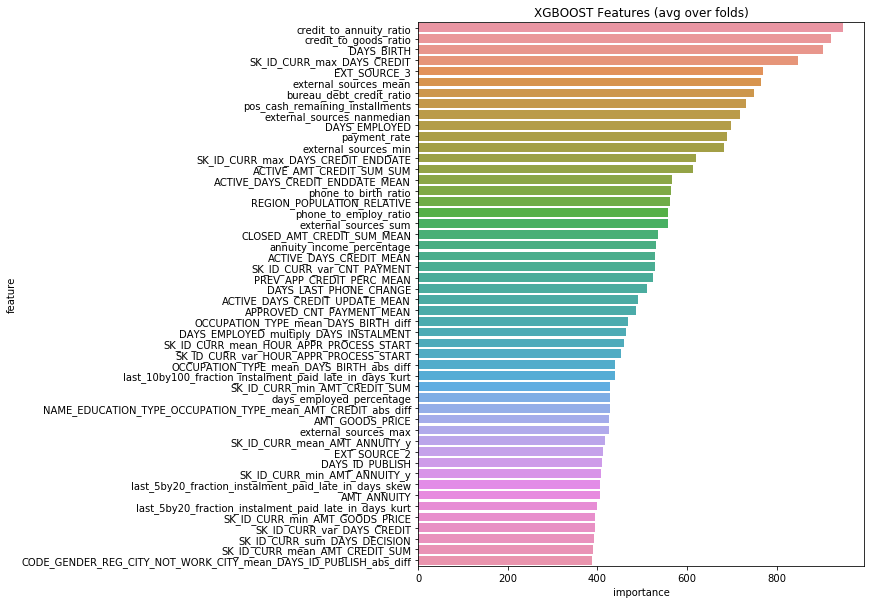

In [102]:
display_importances(fold_importance_df_xgb1)

In [103]:
importance_xgb1 = get_importances(fold_importance_df_xgb1)

In [104]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb1')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb1.to_csv(os.path.join(SaveDirPath,"importance_xgb1.csv"))
sub_xgb1.to_csv(os.path.join(SaveDirPath,"sub_xgb1.csv"), index=False)
subtmp_xgb1.to_csv(os.path.join(SaveDirPath,"oof_test_xgb1.csv"), index=False)
oof_train_xgb1 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb1})
oof_train_xgb1.to_csv(os.path.join(SaveDirPath,"oof_train_xgb1.csv"), index=False)

### 2.2 xgb2_0796

In [134]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb2 = np.zeros(df_train.shape[0])
sub_preds_xgb2 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb2 = []
feature_importance_df_xgb2 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'learning_rate': 0.02,
                      'max_leaves': 5,
                      'max_depth': 5,
                      'subsample': 0.8,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 1,
                      'min_child_weight': 5,
                      'lambda': 3,
                      'alpha':0.0,
                      'nthread':-1,
                      'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb2[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb2[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb2 = roc_auc_score(valid_y, oof_preds_xgb2[valid_idx])
    roc_score_list_xgb2.append(roc_curr_xgb2)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb2 ))
    
    importance_xgb2 = clf.get_fscore()
    fold_importance_df_xgb2 = pd.DataFrame(list(importance_xgb2.items()), columns=['feature','importance'])
    fold_importance_df_xgb2["fold"] = n_fold + 1
    feature_importance_df_xgb2 = pd.concat([feature_importance_df_xgb2, fold_importance_df_xgb2], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1129), test shape: (48744, 1129)
Num of Feature: 1127
[08:14:38] Allocated 594MB on [0] GeForce GTX 1080 Ti, 10125MB remaining.
[08:14:39] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10119MB remaining.
[08:14:39] Allocated 29MB on [0] GeForce GTX 1080 Ti, 10089MB remaining.
[08:14:39] Allocated 443MB on [0] GeForce GTX 1080 Ti, 9641MB remaining.
[0]	train-auc:0.649404	valid-auc:0.64931
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.748186	valid-auc:0.747016
[400]	train-auc:0.769544	valid-auc:0.765458
[600]	train-auc:0.77878	valid-auc:0.772517
[800]	train-auc:0.784922	valid-auc:0.776803
[1000]	train-auc:0.789517	valid-auc:0.779639
[1200]	train-auc:0.793418	valid-auc:0.781811
[1400]	train-auc:0.796649	valid-auc:0.783342
[1600]	train-auc:0.799502	valid-auc:0.784634
[1800]	train-auc:0.802022	valid-auc:0.785647
[2000]	train-auc:0.804347	val

[08:56:42] Allocated 364MB on [0] GeForce GTX 1080 Ti, 9270MB remaining.
Fold  5 AUC : 0.789053


In [135]:
np.mean(roc_score_list_xgb2)

0.7907366962364771

In [136]:
subtmp_xgb2,sub_xgb2 = subtest(sub_preds_xgb2)

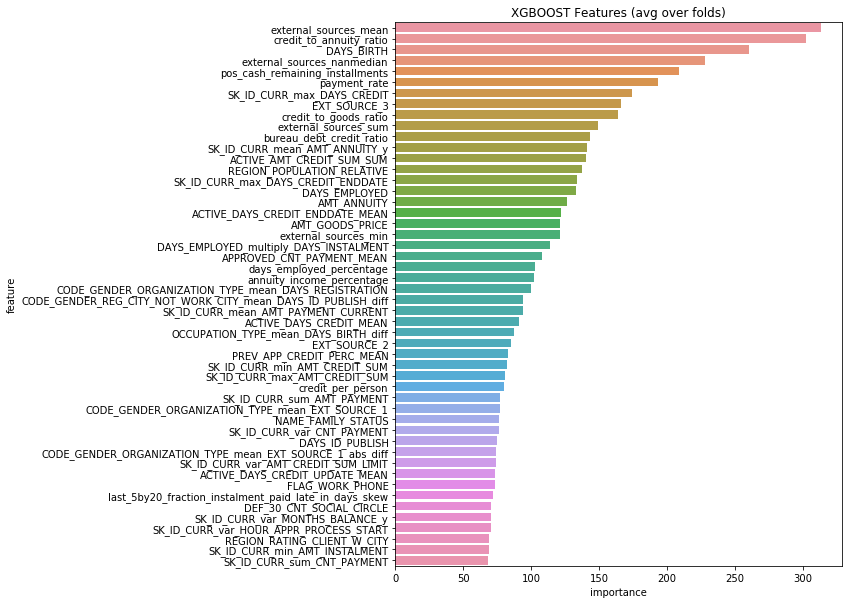

In [137]:
display_importances(fold_importance_df_xgb2)

In [138]:
importance_xgb2 = get_importances(fold_importance_df_xgb2)

In [142]:
importance_xgb2

,importance
feature,
external_sources_mean,313
credit_to_annuity_ratio,302
DAYS_BIRTH,260
external_sources_nanmedian,228
pos_cash_remaining_installments,209
payment_rate,193
SK_ID_CURR_max_DAYS_CREDIT,174
EXT_SOURCE_3,166
credit_to_goods_ratio,164


In [143]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb2')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb2.to_csv(os.path.join(SaveDirPath,"importance_xgb2.csv"))
sub_xgb2.to_csv(os.path.join(SaveDirPath,"sub_xgb2.csv"), index=False)
subtmp_xgb2.to_csv(os.path.join(SaveDirPath,"oof_test_xgb2.csv"), index=False)
oof_train_xgb2 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb2})
oof_train_xgb2.to_csv(os.path.join(SaveDirPath,"oof_train_xgb2.csv"), index=False)

### 2.3 xgb_0801

In [32]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds_xgb3 = np.zeros(df_train.shape[0])
sub_preds_xgb3 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb3 = []
feature_importance_df_xgb3 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.8,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 2}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb3[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb3[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb3 = roc_auc_score(valid_y, oof_preds_xgb3[valid_idx])
    roc_score_list_xgb3.append(roc_curr_xgb3)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb3))
    
    importance_xgb3 = clf.get_fscore()
    fold_importance_df_xgb3 = pd.DataFrame(list(importance_xgb3.items()), columns=['feature','importance'])
    fold_importance_df_xgb3["fold"] = n_fold + 1
    feature_importance_df_xgb3 = pd.concat([feature_importance_df_xgb3, fold_importance_df_xgb3], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1601), test shape: (48744, 1601)
Num of Feature: 1599
stratified...
[23:21:18] Allocated 844MB on [0] GeForce GTX 1080 Ti, 8119MB remaining.
[23:21:18] Allocated 7MB on [0] GeForce GTX 1080 Ti, 8113MB remaining.
[23:21:18] Allocated 224MB on [0] GeForce GTX 1080 Ti, 7887MB remaining.
[23:21:18] Allocated 655MB on [0] GeForce GTX 1080 Ti, 7231MB remaining.
[0]	train-auc:0.707011	valid-auc:0.707196
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.762099	valid-auc:0.756503
[400]	train-auc:0.782473	valid-auc:0.771955
[600]	train-auc:0.795841	valid-auc:0.780043
[800]	train-auc:0.805129	valid-auc:0.784709
[1000]	train-auc:0.812366	valid-auc:0.787588
[1200]	train-auc:0.81877	valid-auc:0.78956
[1400]	train-auc:0.824315	valid-auc:0.791098
[1600]	train-auc:0.829596	valid-auc:0.79236
[1800]	train-auc:0.834318	valid-auc:0.793198
[2000]	train-auc:0

[5800]	train-auc:0.901692	valid-auc:0.791
Stopping. Best iteration:
[5635]	train-auc:0.899632	valid-auc:0.791041

[00:44:44] Allocated 533MB on [0] GeForce GTX 1080 Ti, 8431MB remaining.
Fold  5 AUC : 0.791041


In [33]:
np.mean(roc_score_list_xgb3)

0.7929726302767872

In [34]:
subtmp_xgb3,sub_xgb3 = subtest(sub_preds_xgb3)

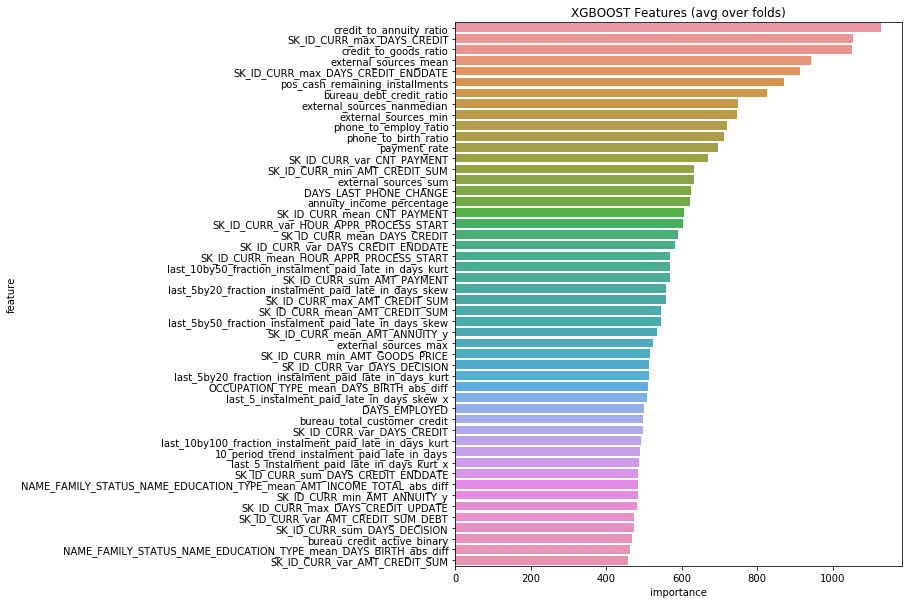

In [35]:
display_importances(fold_importance_df_xgb3)

In [36]:
importance_xgb3 = get_importances(fold_importance_df_xgb3)

In [37]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb3')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb3.to_csv(os.path.join(SaveDirPath,"importance_xgb3.csv"))
sub_xgb3.to_csv(os.path.join(SaveDirPath,"sub_xgb3.csv"), index=False)
subtmp_xgb3.to_csv(os.path.join(SaveDirPath,"oof_test_xgb3.csv"), index=False)
oof_train_xgb3 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb3})
oof_train_xgb3.to_csv(os.path.join(SaveDirPath,"oof_train_xgb3.csv"), index=False)

### 2.4xgb_0801

#### 先做pruning


In [116]:
importance_xgb4 = importance_xgb4.importance/importance_xgb4.importance.sum()
importance_xgb4.head()

feature
SK_ID_CURR_max_DAYS_CREDIT            0.006674
credit_to_goods_ratio                 0.006604
payment_rate                          0.006082
SK_ID_CURR_max_DAYS_CREDIT_ENDDATE    0.005777
external_sources_mean                 0.005713
Name: importance, dtype: float64

In [117]:
importance_xgb3_cum = importance_xgb4.cumsum()
importance_xgb3_cum.tail()

feature
OCCUPATION_TYPE_2       0.999975
ORGANIZATION_TYPE_31    0.999981
ORGANIZATION_TYPE_23    0.999987
FONDKAPREMONT_MODE_4    0.999994
ORGANIZATION_TYPE_35    1.000000
Name: importance, dtype: float64

In [118]:
features_keep = importance_xgb3_cum[importance_xgb3_cum<0.98].index.tolist()
len(features_keep)

859

In [65]:
ObjectColNew = list(set(ObjectCol)&set(features_keep))
ObjectColNew

['NAME_CONTRACT_TYPE',
 'OCCUPATION_TYPE',
 'FONDKAPREMONT_MODE',
 'FLAG_OWN_REALTY',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_HOUSING_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE']

In [99]:
features_keep = list(set(features_keep)-set(ObjectColNew))

In [119]:
len(features_keep)

859

In [68]:
X = df_train.append(df_test)
X.reset_index(inplace=True,drop=True)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,1,1,1,1,1
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,2,-1,1
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,2,0,0,0,0,0,-1,0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,3,-1,2


In [98]:
for catname in ObjectColNew:
    X_DUMP = pd.get_dummies(X[catname],prefix=catname)
    X = pd.concat([X,X_DUMP],axis=1)
    print('%s:%d'%(catname,len(X_DUMP.columns.tolist())))
    features_keep.extend(X_DUMP.columns.tolist())

NAME_CONTRACT_TYPE:2
OCCUPATION_TYPE:19
FONDKAPREMONT_MODE:5
FLAG_OWN_REALTY:2
ORGANIZATION_TYPE:58
WALLSMATERIAL_MODE:8
WEEKDAY_APPR_PROCESS_START:7
NAME_HOUSING_TYPE:6
NAME_TYPE_SUITE:8
NAME_INCOME_TYPE:8


In [70]:
len(features_keep)

1071

In [101]:
df_train = X[~X.TARGET.isnull()]
df_train.reset_index(drop=True, inplace=True)
df_test = X[X.TARGET.isnull()]
df_test.reset_index(drop=True, inplace=True)

In [120]:
del X
gc.collect()

26720

In [103]:
df_train.shape

(307511, 1724)

In [121]:
feats_old = features

In [122]:
features = features_keep

In [105]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds_xgb3 = np.zeros(df_train.shape[0])
sub_preds_xgb3 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb3 = []
feature_importance_df_xgb3 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.8,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 2}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb3[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb3[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb3 = roc_auc_score(valid_y, oof_preds_xgb3[valid_idx])
    roc_score_list_xgb3.append(roc_curr_xgb3)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb3))
    
    importance_xgb3 = clf.get_fscore()
    fold_importance_df_xgb3 = pd.DataFrame(list(importance_xgb3.items()), columns=['feature','importance'])
    fold_importance_df_xgb3["fold"] = n_fold + 1
    feature_importance_df_xgb3 = pd.concat([feature_importance_df_xgb3, fold_importance_df_xgb3], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1724), test shape: (48744, 1724)
Num of Feature: 1071
stratified...
[01:43:05] Allocated 565MB on [0] GeForce GTX 1080 Ti, 10143MB remaining.
[01:43:06] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10137MB remaining.
[01:43:06] Allocated 177MB on [0] GeForce GTX 1080 Ti, 9959MB remaining.
[01:43:06] Allocated 430MB on [0] GeForce GTX 1080 Ti, 9523MB remaining.
[0]	train-auc:0.700224	valid-auc:0.702705
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.761993	valid-auc:0.75672
[400]	train-auc:0.782565	valid-auc:0.772112
[600]	train-auc:0.795888	valid-auc:0.780434
[800]	train-auc:0.805223	valid-auc:0.784791
[1000]	train-auc:0.812381	valid-auc:0.787563
[1200]	train-auc:0.818515	valid-auc:0.789672
[1400]	train-auc:0.82405	valid-auc:0.791284
[1600]	train-auc:0.829198	valid-auc:0.792505
[1800]	train-auc:0.833993	valid-auc:0.793407
[2000]	train-au

[4000]	train-auc:0.875722	valid-auc:0.790868
[4200]	train-auc:0.878868	valid-auc:0.790871
[4400]	train-auc:0.881884	valid-auc:0.790956
[4600]	train-auc:0.884957	valid-auc:0.791072
[4800]	train-auc:0.887735	valid-auc:0.791136
[5000]	train-auc:0.890609	valid-auc:0.791195
[5200]	train-auc:0.89333	valid-auc:0.791368
[5400]	train-auc:0.896087	valid-auc:0.791305
Stopping. Best iteration:
[5219]	train-auc:0.893606	valid-auc:0.791391

[02:44:51] Allocated 350MB on [0] GeForce GTX 1080 Ti, 9163MB remaining.
Fold  5 AUC : 0.791391


In [106]:
np.mean(roc_score_list_xgb3)

0.7931635314978178

In [107]:
subtmp_xgb4,sub_xgb4 = subtest(sub_preds_xgb3)

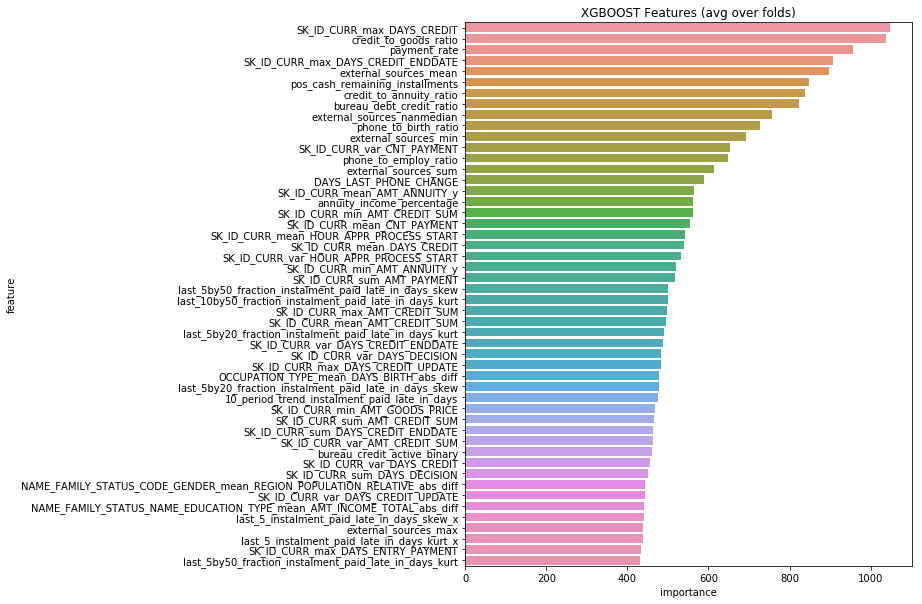

In [108]:
display_importances(fold_importance_df_xgb3)

In [109]:
importance_xgb4 = get_importances(fold_importance_df_xgb3)

In [112]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb4')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb4.to_csv(os.path.join(SaveDirPath,"importance_xgb4.csv"))
sub_xgb4.to_csv(os.path.join(SaveDirPath,"sub_xgb4.csv"), index=False)
subtmp_xgb4.to_csv(os.path.join(SaveDirPath,"oof_test_xgb4.csv"), index=False)
oof_train_xgb3 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb3})
oof_train_xgb3.to_csv(os.path.join(SaveDirPath,"oof_train_xgb4.csv"), index=False)

### 2.5 xgb

In [141]:
features = feats_old
stratified = False

In [142]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb5 = np.zeros(df_train.shape[0])
sub_preds_xgb5 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb5 = []
feature_importance_df_xgb5 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.8,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 110,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb5[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb5[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb5 = roc_auc_score(valid_y, oof_preds_xgb5[valid_idx])
    roc_score_list_xgb5.append(roc_curr_xgb5)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb5))
    
    importance_xgb5 = clf.get_fscore()
    fold_importance_df_xgb5 = pd.DataFrame(list(importance_xgb5.items()), columns=['feature','importance'])
    fold_importance_df_xgb5["fold"] = n_fold + 1
    feature_importance_df_xgb5 = pd.concat([feature_importance_df_xgb5, fold_importance_df_xgb5], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1724), test shape: (48744, 1724)
Num of Feature: 1071
KFold...
[05:08:05] Allocated 565MB on [0] GeForce GTX 1080 Ti, 7413MB remaining.
[05:08:06] Allocated 7MB on [0] GeForce GTX 1080 Ti, 7413MB remaining.
[05:08:06] Allocated 177MB on [0] GeForce GTX 1080 Ti, 7413MB remaining.
[05:08:06] Allocated 430MB on [0] GeForce GTX 1080 Ti, 6981MB remaining.
[0]	train-auc:0.686556	valid-auc:0.690407
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.750444	valid-auc:0.743289
[400]	train-auc:0.774651	valid-auc:0.761882
[600]	train-auc:0.789854	valid-auc:0.772733
[800]	train-auc:0.799748	valid-auc:0.778342
[1000]	train-auc:0.807045	valid-auc:0.781774
[1200]	train-auc:0.813128	valid-auc:0.784118
[1400]	train-auc:0.818506	valid-auc:0.785897
[1600]	train-auc:0.823507	valid-auc:0.787147
[1800]	train-auc:0.827958	valid-auc:0.788121
[2000]	train-auc:0.8

In [143]:
subtmp_xgb5,sub_xgb5 = subtest(sub_preds_xgb5)

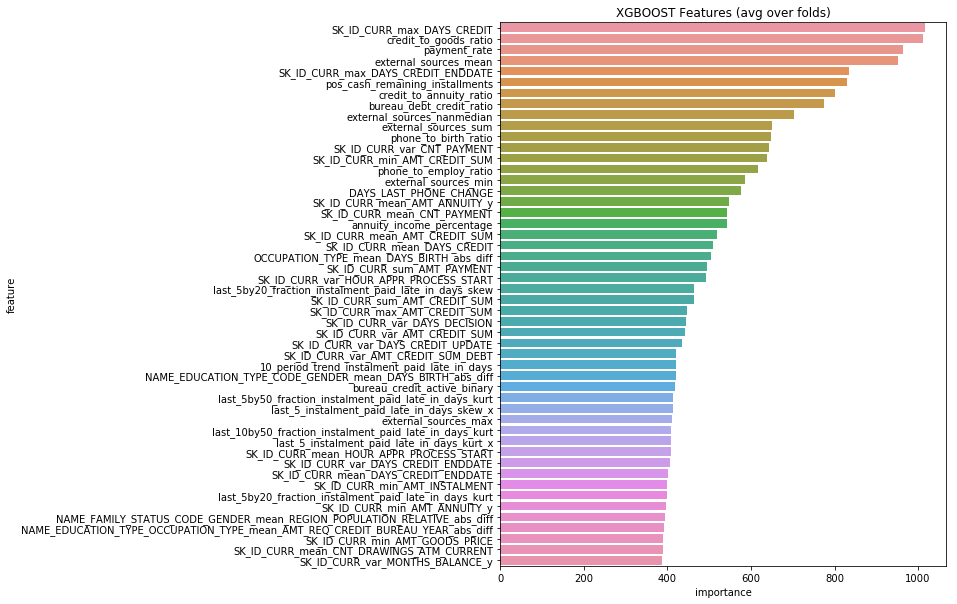

In [144]:
display_importances(fold_importance_df_xgb5)

In [145]:
importance_xgb5 = get_importances(fold_importance_df_xgb5)

In [146]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb5')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb5.to_csv(os.path.join(SaveDirPath,"importance_xgb5.csv"))
sub_xgb5.to_csv(os.path.join(SaveDirPath,"sub_xgb5.csv"), index=False)
subtmp_xgb5.to_csv(os.path.join(SaveDirPath,"oof_test_xgb5.csv"), index=False)
oof_train_xgb5 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb5})
oof_train_xgb5.to_csv(os.path.join(SaveDirPath,"oof_train_xgb5.csv"), index=False)

### 2.6 xgb_802

In [155]:
X_Train = loadData('AllTrain_withnull.csv')
X_Test = loadData('AllTest_withnull.csv')

In [156]:
X_ALL = X_Train.append(X_Test)
X_ALL.reset_index(drop=True,inplace=True)
X_ALL.head()

,100_period_trend_instalment_paid_late_in_days,100_period_trend_instalment_paid_over_amount,10_period_trend_instalment_paid_late_in_days,10_period_trend_instalment_paid_over_amount,12_period_trend_SK_DPD,12_period_trend_SK_DPD_DEF,180_period_trend_days_credit_diff,1_period_trend_SK_DPD,1_period_trend_SK_DPD_DEF,30_period_trend_SK_DPD,...,previous_application_days_first_drawing_last_1_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_days_first_drawing_last_5_credits_mean,previous_application_number_of_prev_application,previous_application_prev_was_approved,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,retirement_age
0,-0.568421,0.000000,0.012121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,365243.0,365243.0,365243.0,1.0,1.0,0.0,24.0,24.0,24.0,0
1,-0.085385,0.000000,-0.193939,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,365243.0,365243.0,365243.0,3.0,1.0,0.0,12.0,10.0,10.0,1
2,-4.000000,0.000000,-4.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,365243.0,365243.0,365243.0,1.0,1.0,0.0,4.0,4.0,4.0,1
3,-3.588235,0.000000,-0.787879,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,365243.0,9.0,0.0,1.0,48.0,48.0,24.0,1
4,0.114560,-10.699939,-0.400000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,365243.0,365243.0,365243.0,6.0,1.0,0.0,24.0,30.0,22.8,1


In [157]:
X_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 1341 entries, 100_period_trend_instalment_paid_late_in_days to retirement_age
dtypes: float64(1183), int64(158)
memory usage: 3.6 GB


In [158]:
X = df_train.append(df_test)
X.reset_index(inplace=True,drop=True)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,NAME_TYPE_SUITE_6,NAME_TYPE_SUITE_7,NAME_INCOME_TYPE_0,NAME_INCOME_TYPE_1,NAME_INCOME_TYPE_2,NAME_INCOME_TYPE_3,NAME_INCOME_TYPE_4,NAME_INCOME_TYPE_5,NAME_INCOME_TYPE_6,NAME_INCOME_TYPE_7
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [162]:
feat50 = importance_xgb5.iloc[:100].index.tolist()
feat50

['SK_ID_CURR_max_DAYS_CREDIT',
 'credit_to_goods_ratio',
 'payment_rate',
 'external_sources_mean',
 'SK_ID_CURR_max_DAYS_CREDIT_ENDDATE',
 'pos_cash_remaining_installments',
 'credit_to_annuity_ratio',
 'bureau_debt_credit_ratio',
 'external_sources_nanmedian',
 'external_sources_sum',
 'phone_to_birth_ratio',
 'SK_ID_CURR_var_CNT_PAYMENT',
 'SK_ID_CURR_min_AMT_CREDIT_SUM',
 'phone_to_employ_ratio',
 'external_sources_min',
 'DAYS_LAST_PHONE_CHANGE',
 'SK_ID_CURR_mean_AMT_ANNUITY_y',
 'SK_ID_CURR_mean_CNT_PAYMENT',
 'annuity_income_percentage',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM',
 'SK_ID_CURR_mean_DAYS_CREDIT',
 'OCCUPATION_TYPE_mean_DAYS_BIRTH_abs_diff',
 'SK_ID_CURR_sum_AMT_PAYMENT',
 'SK_ID_CURR_var_HOUR_APPR_PROCESS_START',
 'last_5by20_fraction_instalment_paid_late_in_days_skew',
 'SK_ID_CURR_sum_AMT_CREDIT_SUM',
 'SK_ID_CURR_max_AMT_CREDIT_SUM',
 'SK_ID_CURR_var_DAYS_DECISION',
 'SK_ID_CURR_var_AMT_CREDIT_SUM',
 'SK_ID_CURR_var_DAYS_CREDIT_UPDATE',
 'SK_ID_CURR_var_AMT_CREDIT_SUM

In [167]:
featsAdd = ['pos_cash_remaining_installments','bureau_debt_credit_ratio',
           'OCCUPATION_TYPE_mean_DAYS_BIRTH_abs_diff','last_5by20_fraction_instalment_paid_late_in_days_skew',
           '10_period_trend_instalment_paid_late_in_days','NAME_EDUCATION_TYPE_CODE_GENDER_mean_DAYS_BIRTH_abs_diff',
           'bureau_credit_active_binary','last_5_instalment_paid_late_in_days_skew_x',
           'last_5by50_fraction_instalment_paid_late_in_days_kurt','last_10by50_fraction_instalment_paid_late_in_days_kurt',
           'last_5_instalment_paid_late_in_days_kurt_x', 'last_5by20_fraction_instalment_paid_late_in_days_kurt',
           'NAME_FAMILY_STATUS_CODE_GENDER_mean_REGION_POPULATION_RELATIVE_abs_diff',
           'OCCUPATION_TYPE_mean_DAYS_BIRTH_diff',
           'NAME_FAMILY_STATUS_CODE_GENDER_mean_DAYS_BIRTH_abs_diff',
           'OCCUPATION_TYPE_mean_AMT_ANNUITY_abs_diff','NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_mean_AMT_INCOME_TOTAL_abs_diff',
           'last_5_instalment_paid_late_in_days_max_y',
           'last_10_instalment_paid_late_in_days_max_y','NAME_FAMILY_STATUS_CODE_GENDER_mean_DAYS_EMPLOYED_diff',
           '50_period_trend_instalment_paid_late_in_days',
           'last_10_instalment_paid_late_in_days_skew_x','last_20_instalment_paid_late_in_days_kurt_y','last_50_instalment_paid_late_in_days_skew_x',
           'NAME_EDUCATION_TYPE_CODE_GENDER_max_AMT_ANNUITY_abs_diff',
           'OCCUPATION_TYPE_mean_DAYS_ID_PUBLISH_abs_diff',
           'last_10by100_fraction_instalment_paid_late_in_days_skew',
           ]

In [169]:
len(featsAdd)

18

In [168]:
featsAdd = list(set(featsAdd) - set(X_ALL.columns.tolist()))
len(featsAdd)

18

In [174]:
X_ALL = pd.concat([X_ALL,X[featsAdd]],axis=1)
X_ALL.head()

,100_period_trend_instalment_paid_late_in_days,100_period_trend_instalment_paid_over_amount,10_period_trend_instalment_paid_late_in_days,10_period_trend_instalment_paid_over_amount,12_period_trend_SK_DPD,12_period_trend_SK_DPD_DEF,180_period_trend_days_credit_diff,1_period_trend_SK_DPD,1_period_trend_SK_DPD_DEF,30_period_trend_SK_DPD,...,last_10_instalment_paid_late_in_days_skew_x,NAME_FAMILY_STATUS_CODE_GENDER_mean_DAYS_BIRTH_abs_diff,last_20_instalment_paid_late_in_days_kurt_y,NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_mean_AMT_INCOME_TOTAL_abs_diff,last_5by20_fraction_instalment_paid_late_in_days_skew,last_5by20_fraction_instalment_paid_late_in_days_kurt,last_5_instalment_paid_late_in_days_max_y,NAME_FAMILY_STATUS_CODE_GENDER_mean_REGION_POPULATION_RELATIVE_abs_diff,NAME_EDUCATION_TYPE_CODE_GENDER_max_AMT_ANNUITY_abs_diff,last_5_instalment_paid_late_in_days_skew_x
0,-0.568421,0.000000,0.012121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.413127,2972.362433,-0.474798,48118.423977,2.607188,1.467762,-12.0,0.002460,152995.5,-0.793502
1,-0.085385,0.000000,-0.193939,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,-0.644795,450.277916,-0.686793,58090.823702,1.537067,0.937590,-3.0,0.017104,194463.0,-0.961016
2,-4.000000,0.000000,-4.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.528005,6612.637567,-1.500000,86881.576023,1.000000,1.000000,-3.0,0.011229,170946.0,0.528005
3,-3.588235,0.000000,-0.787879,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,-1.570488,3664.948158,0.729164,22719.615717,0.786713,-0.457936,-1.0,0.012803,186903.0,-1.150049
4,0.114560,-10.699939,-0.400000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.000000,7498.637567,2.414040,32881.576023,-0.000000,-0.724926,0.0,0.007402,155830.5,0.000000


In [175]:
features = [x for x in X_ALL.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [176]:
len(features)

1357

In [177]:
df_train = X_ALL[~X_ALL.TARGET.isnull()]
df_train.reset_index(drop=True, inplace=True)
df_test = X_ALL[X_ALL.TARGET.isnull()]
df_test.reset_index(drop=True, inplace=True)

In [178]:
del X
del X_ALL
gc.collect()

26347

In [179]:
del X_Train
del X_Test
gc.collect()

14

In [181]:
del X_null
gc.collect()

275

In [182]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb6 = np.zeros(df_train.shape[0])
sub_preds_xgb6 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb6 = []
feature_importance_df_xgb6 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.8,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb6[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb6[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb6 = roc_auc_score(valid_y, oof_preds_xgb6[valid_idx])
    roc_score_list_xgb6.append(roc_curr_xgb6)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb6))
    
    importance_xgb6 = clf.get_fscore()
    fold_importance_df_xgb6 = pd.DataFrame(list(importance_xgb6.items()), columns=['feature','importance'])
    fold_importance_df_xgb6["fold"] = n_fold + 1
    feature_importance_df_xgb6 = pd.concat([feature_importance_df_xgb6, fold_importance_df_xgb6], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1359), test shape: (48744, 1359)
Num of Feature: 1357
KFold...
[07:13:24] Allocated 716MB on [0] GeForce GTX 1080 Ti, 10002MB remaining.
[07:13:25] Allocated 7MB on [0] GeForce GTX 1080 Ti, 9996MB remaining.
[07:13:25] Allocated 176MB on [0] GeForce GTX 1080 Ti, 9818MB remaining.
[07:13:25] Allocated 486MB on [0] GeForce GTX 1080 Ti, 9328MB remaining.
[0]	train-auc:0.683234	valid-auc:0.685724
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.752648	valid-auc:0.743875
[400]	train-auc:0.777701	valid-auc:0.764237
[600]	train-auc:0.792988	valid-auc:0.775493
[800]	train-auc:0.802713	valid-auc:0.78096
[1000]	train-auc:0.810269	valid-auc:0.784547
[1200]	train-auc:0.816513	valid-auc:0.78708
[1400]	train-auc:0.82195	valid-auc:0.788735
[1600]	train-auc:0.826937	valid-auc:0.790108
[1800]	train-auc:0.831333	valid-auc:0.791043
[2000]	train-auc:0.835

[4400]	train-auc:0.874354	valid-auc:0.793513
[4600]	train-auc:0.877138	valid-auc:0.793637
[4800]	train-auc:0.879756	valid-auc:0.793674
[5000]	train-auc:0.882431	valid-auc:0.793757
[5200]	train-auc:0.885092	valid-auc:0.793837
[5400]	train-auc:0.887585	valid-auc:0.793904
Stopping. Best iteration:
[5363]	train-auc:0.887137	valid-auc:0.793925

[08:18:32] Allocated 401MB on [0] GeForce GTX 1080 Ti, 8918MB remaining.
Fold  5 AUC : 0.793925


In [183]:
np.mean(roc_score_list_xgb6)

0.7954902846693894

In [184]:
subtmp_xgb6,sub_xgb6 = subtest(sub_preds_xgb6)

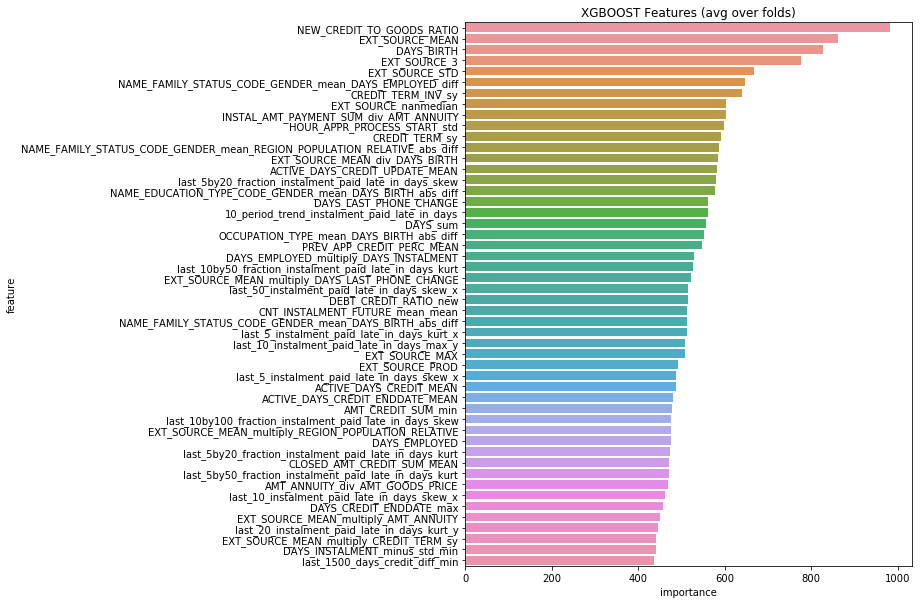

In [185]:
display_importances(fold_importance_df_xgb6)

In [186]:
importance_xgb6 = get_importances(fold_importance_df_xgb6)

In [187]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb6')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb6.to_csv(os.path.join(SaveDirPath,"importance_xgb6.csv"))
sub_xgb6.to_csv(os.path.join(SaveDirPath,"sub_xgb6.csv"), index=False)
subtmp_xgb6.to_csv(os.path.join(SaveDirPath,"oof_test_xgb6.csv"), index=False)
oof_train_xgb6 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb6})
oof_train_xgb6.to_csv(os.path.join(SaveDirPath,"oof_train_xgb6.csv"), index=False)

### 2.7 xgb_0803

In [21]:
features.remove('NEW_CREDIT_TO_ANNUITY_RATIO')
len(features)

1357

In [22]:
stratified = False

In [21]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb6 = np.zeros(df_train.shape[0])
sub_preds_xgb6 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb6 = []
feature_importance_df_xgb6 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.7,
                      'colsample_bytree': 0.6,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb6[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb6[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb6 = roc_auc_score(valid_y, oof_preds_xgb6[valid_idx])
    roc_score_list_xgb6.append(roc_curr_xgb6)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb6))
    
    importance_xgb6 = clf.get_fscore()
    fold_importance_df_xgb6 = pd.DataFrame(list(importance_xgb6.items()), columns=['feature','importance'])
    fold_importance_df_xgb6["fold"] = n_fold + 1
    feature_importance_df_xgb6 = pd.concat([feature_importance_df_xgb6, fold_importance_df_xgb6], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1360), test shape: (48744, 1360)
Num of Feature: 1358
KFold...
[12:51:19] Allocated 716MB on [0] GeForce GTX 1080 Ti, 10032MB remaining.
[12:51:20] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10026MB remaining.
[12:51:20] Allocated 176MB on [0] GeForce GTX 1080 Ti, 9848MB remaining.
[12:51:20] Allocated 486MB on [0] GeForce GTX 1080 Ti, 9356MB remaining.
[0]	train-auc:0.686765	valid-auc:0.689973
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.752141	valid-auc:0.744272
[400]	train-auc:0.776479	valid-auc:0.763991
[600]	train-auc:0.791818	valid-auc:0.775217
[800]	train-auc:0.801478	valid-auc:0.780861
[1000]	train-auc:0.808902	valid-auc:0.784569
[1200]	train-auc:0.815084	valid-auc:0.787032
[1400]	train-auc:0.820462	valid-auc:0.788797
[1600]	train-auc:0.825417	valid-auc:0.790051
[1800]	train-auc:0.829798	valid-auc:0.79089
[2000]	train-auc:0.

[2200]	train-auc:0.837684	valid-auc:0.790388
[2400]	train-auc:0.841345	valid-auc:0.790921
[2600]	train-auc:0.844855	valid-auc:0.791517
[2800]	train-auc:0.84826	valid-auc:0.791949
[3000]	train-auc:0.851579	valid-auc:0.792354
[3200]	train-auc:0.854792	valid-auc:0.79264
[3400]	train-auc:0.857856	valid-auc:0.792937
[3600]	train-auc:0.860933	valid-auc:0.79314
[3800]	train-auc:0.863988	valid-auc:0.793356
[4000]	train-auc:0.867002	valid-auc:0.793556
[4200]	train-auc:0.869848	valid-auc:0.793727
[4400]	train-auc:0.87265	valid-auc:0.793887
[4600]	train-auc:0.875324	valid-auc:0.794032
[4800]	train-auc:0.877969	valid-auc:0.794092
[5000]	train-auc:0.88063	valid-auc:0.794137
[5200]	train-auc:0.883172	valid-auc:0.794188
[5400]	train-auc:0.885669	valid-auc:0.794266
[5600]	train-auc:0.888033	valid-auc:0.794329
[5800]	train-auc:0.89046	valid-auc:0.794419
[6000]	train-auc:0.892834	valid-auc:0.794457
Stopping. Best iteration:
[5985]	train-auc:0.89266	valid-auc:0.794472

[14:12:49] Allocated 402MB on [0] G

In [22]:
np.mean(roc_score_list_xgb6)

0.7956950923442764

In [30]:
np.std(roc_score_list_xgb6)

0.0022741485461354742

In [23]:
subtmp_xgb7,sub_xgb7 = subtest(sub_preds_xgb6)

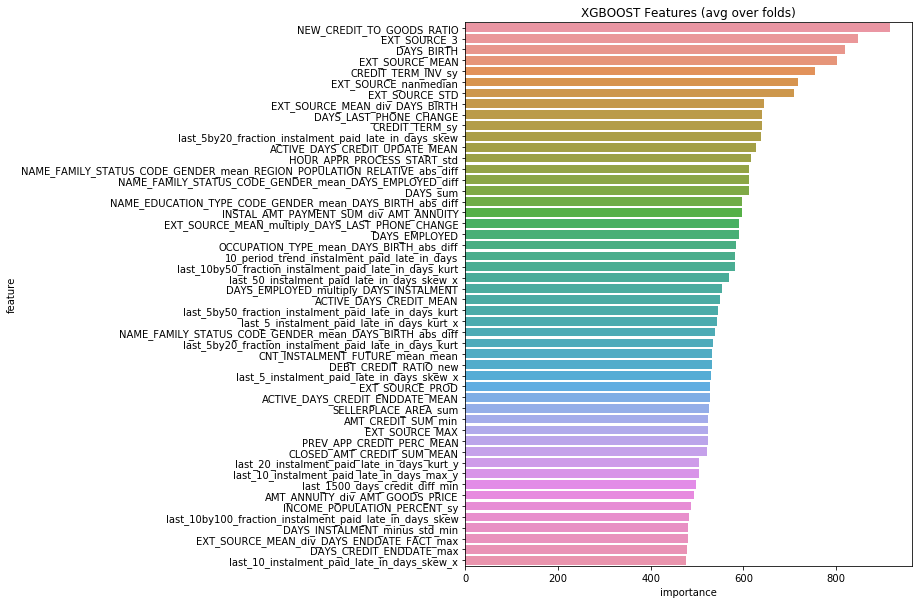

In [24]:
display_importances(fold_importance_df_xgb6)

In [25]:
importance_xgb7 = get_importances(fold_importance_df_xgb6)

In [29]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb7')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb7.to_csv(os.path.join(SaveDirPath,"importance_xgb7.csv"))
sub_xgb7.to_csv(os.path.join(SaveDirPath,"sub_xgb7.csv"), index=False)
subtmp_xgb7.to_csv(os.path.join(SaveDirPath,"oof_test_xgb7.csv"), index=False)
oof_train_xgb6 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb6})
oof_train_xgb6.to_csv(os.path.join(SaveDirPath,"oof_train_xgb7.csv"), index=False)

### 2.8 xgb_0802

In [48]:
feats50 = pd.read_csv(os.path.join(TrainTestDataDir,'feats50.csv'),index_col=0)
feats50.head()

,i377,i12,i228,i21,i9,i24,i31,i473,i6,i324,...,i144,i331,i413,i20,i14,i52,i2,i0,i384,i219
0,-0.054618,1.000000,-0.257269,0.987110,0.860917,0.665444,0.651959,2.391086e-01,1.000000,3.716091e-01,...,0.393983,-2.065329e-01,0.002382,0.902699,-0.875747,-0.854440,1.000000,1.000000,0.860961,0.015672
1,0.900507,-0.771150,0.683870,-0.672107,-0.999617,-0.879538,-1.000000,-2.262885e-01,-0.978213,-7.702719e-02,...,-0.140514,-1.494355e-01,0.055334,0.739106,-0.875747,0.067379,-0.898295,-0.864933,0.020692,-0.000488
2,-0.180987,0.747287,0.255545,0.999988,-0.999726,-0.830344,0.732450,-8.000064e-08,-0.655366,6.917326e-01,...,0.457032,8.863240e-03,-0.109869,-0.999993,-0.875747,0.780167,-0.970419,-0.997806,-0.186186,-0.065754
3,0.890207,0.761691,-0.596493,0.281368,0.349752,0.993307,0.567285,-8.000064e-08,0.768770,5.725534e-08,...,-0.629450,-6.092590e-07,0.220543,-0.997404,-0.963728,0.338877,-0.867688,-0.653651,-0.965407,-0.020672
4,0.148859,-0.870182,0.185412,0.971740,-0.855524,0.283858,0.736633,-8.000064e-08,0.643068,6.309666e-02,...,-0.817357,-1.494355e-01,0.174868,-0.997524,-0.875747,-0.437826,0.982404,0.966326,-0.002103,0.053902


In [49]:
X = df_train.append(df_test)
X.reset_index(inplace=True,drop=True)
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,AMT_GOODS_PRICE_div_DAYS_BIRTH,INSTAL_AMT_PAYMENT_SUM_div_DAYS_EMPLOYED,AMT_PAYMENT_minus_Total_max_mean,last_1_pos_cash_paid_late_count,BURO_AMT_CREDIT_SUM_MEAN,CNT_DRAWINGS_POS_CURRENT_max_mean,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Industry: type 7,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_LIMIT_ACTUAL_std_max
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-37.099672,-344.781311,NaN,1.0,108131.945625,NaN,0,0,780.0,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-67.372502,-1362.680682,NaN,1.0,254350.125000,NaN,0,0,1216.0,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.088102,-94.615400,NaN,1.0,94518.900000,NaN,0,0,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-15.627466,-331.409482,NaN,1.0,NaN,NaN,0,0,NaN,0.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-25.737508,-265.348247,NaN,1.0,146250.000000,NaN,0,0,NaN,NaN


In [50]:
X = pd.concat([X,feats50],axis=1)

In [51]:
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,i144,i331,i413,i20,i14,i52,i2,i0,i384,i219
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.393983,-2.065329e-01,0.002382,0.902699,-0.875747,-0.854440,1.000000,1.000000,0.860961,0.015672
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.140514,-1.494355e-01,0.055334,0.739106,-0.875747,0.067379,-0.898295,-0.864933,0.020692,-0.000488
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457032,8.863240e-03,-0.109869,-0.999993,-0.875747,0.780167,-0.970419,-0.997806,-0.186186,-0.065754
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.629450,-6.092590e-07,0.220543,-0.997404,-0.963728,0.338877,-0.867688,-0.653651,-0.965407,-0.020672
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.817357,-1.494355e-01,0.174868,-0.997524,-0.875747,-0.437826,0.982404,0.966326,-0.002103,0.053902


In [52]:
df_train = X[~X.TARGET.isnull()]
df_train.reset_index(drop=True, inplace=True)
df_test = X[X.TARGET.isnull()]
df_test.reset_index(drop=True, inplace=True)

In [53]:
features = [x for x in df_train.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [54]:
features.remove('NEW_CREDIT_TO_ANNUITY_RATIO')
len(features)

2622

In [55]:
#features.extend(feats50.columns.tolist())
#len(features)

In [56]:
del X
gc.collect()

0

In [57]:
num_folds = 5
stratified = False
debug= False

In [75]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb8 = np.zeros(df_train.shape[0])
sub_preds_xgb8 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb8 = []
feature_importance_df_xgb8 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 35,
                      'max_depth': 16,
                      'subsample': 0.7,
                      'colsample_bytree': 0.6,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb8[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb8[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb8 = roc_auc_score(valid_y, oof_preds_xgb8[valid_idx])
    roc_score_list_xgb8.append(roc_curr_xgb8)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb8))
    
    importance_xgb8 = clf.get_fscore()
    fold_importance_df_xgb8 = pd.DataFrame(list(importance_xgb8.items()), columns=['feature','importance'])
    fold_importance_df_xgb8["fold"] = n_fold + 1
    feature_importance_df_xgb8 = pd.concat([feature_importance_df_xgb8, fold_importance_df_xgb8], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1409), test shape: (48744, 1409)
Num of Feature: 800
KFold...


KeyboardInterrupt: 

In [32]:
np.mean(roc_score_list_xgb8)

0.7963386188859165

In [33]:
np.std(roc_score_list_xgb8)

0.002572060230682771

In [36]:
subtmp_xgb8,sub_xgb8 = subtest(sub_preds_xgb8)

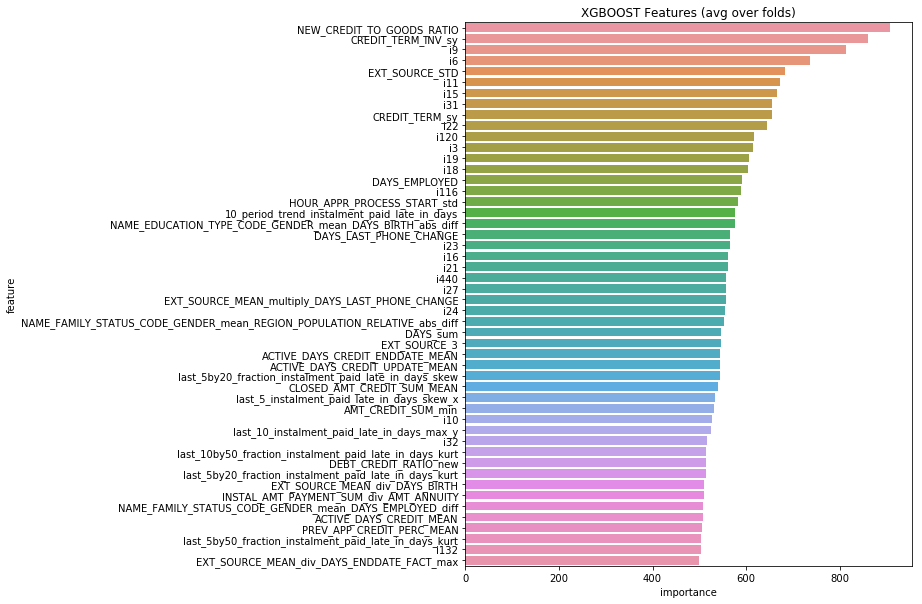

In [37]:
display_importances(fold_importance_df_xgb8)

In [38]:
importance_xgb8 = get_importances(fold_importance_df_xgb8)

In [39]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb8')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb8.to_csv(os.path.join(SaveDirPath,"importance_xgb8.csv"))
sub_xgb8.to_csv(os.path.join(SaveDirPath,"sub_xgb8.csv"), index=False)
subtmp_xgb8.to_csv(os.path.join(SaveDirPath,"oof_test_xgb8.csv"), index=False)
oof_train_xgb8 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb8})
oof_train_xgb8.to_csv(os.path.join(SaveDirPath,"oof_train_xgb8.csv"), index=False)

### 2.9 xgb_0801

In [40]:
importance_xgb8.head()

,importance
feature,
NEW_CREDIT_TO_GOODS_RATIO,908
CREDIT_TERM_INV_sy,861
i9,814
i6,737
EXT_SOURCE_STD,682


In [43]:
importance_cum = importance_xgb8.importance/importance_xgb8.importance.sum()
importance_cum = importance_cum.cumsum()
importance_cum.head()

feature
NEW_CREDIT_TO_GOODS_RATIO    0.004945
CREDIT_TERM_INV_sy           0.009633
i9                           0.014066
i6                           0.018079
EXT_SOURCE_STD               0.021793
Name: importance, dtype: float64

In [68]:
features_keep = importance_cum[importance_cum<0.98].index.tolist()
len(features_keep)

822

In [69]:
len(set(feats50.columns.tolist())&set(features_keep))#这么说起来这个特征还挺powerful

50

In [70]:
feat50name = feats50.columns.tolist()
print(feat50name[:5])
np.random.shuffle(feat50name)
print(feat50name[:5])

['i377', 'i12', 'i228', 'i21', 'i9']
['i21', 'i24', 'i3', 'i324', 'i440']


In [71]:
feats_remove = feat50name[:22]

In [72]:
for r in feats_remove:
    if r in features_keep:
        print(r)
        features_keep.remove(r)

i21
i24
i3
i324
i440
i331
i377
i219
i9
i14
i119
i228
i413
i45
i32
i27
i75
i12
i41
i400
i328
i0


In [74]:
len(features_keep)
features = features_keep

In [76]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb9 = np.zeros(df_train.shape[0])
sub_preds_xgb9 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb9 = []
feature_importance_df_xgb9 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.65,
                      'colsample_bytree': 0.6,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb9[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb9[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb9 = roc_auc_score(valid_y, oof_preds_xgb9[valid_idx])
    roc_score_list_xgb9.append(roc_curr_xgb9)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb9))
    
    importance_xgb9 = clf.get_fscore()
    fold_importance_df_xgb9 = pd.DataFrame(list(importance_xgb9.items()), columns=['feature','importance'])
    fold_importance_df_xgb9["fold"] = n_fold + 1
    feature_importance_df_xgb9 = pd.concat([feature_importance_df_xgb9, fold_importance_df_xgb9], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1409), test shape: (48744, 1409)
Num of Feature: 800
KFold...
[03:26:27] Allocated 422MB on [0] GeForce GTX 1080 Ti, 10323MB remaining.
[03:26:27] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10317MB remaining.
[03:26:27] Allocated 145MB on [0] GeForce GTX 1080 Ti, 10171MB remaining.
[03:26:27] Allocated 291MB on [0] GeForce GTX 1080 Ti, 9875MB remaining.
[0]	train-auc:0.697925	valid-auc:0.697742
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.757895	valid-auc:0.75014
[400]	train-auc:0.778666	valid-auc:0.766669
[600]	train-auc:0.793533	valid-auc:0.777281
[800]	train-auc:0.802905	valid-auc:0.782489
[1000]	train-auc:0.810157	valid-auc:0.785801
[1200]	train-auc:0.816418	valid-auc:0.788173
[1400]	train-auc:0.821769	valid-auc:0.789607
[1600]	train-auc:0.826623	valid-auc:0.790824
[1800]	train-auc:0.831086	valid-auc:0.791649
[2000]	train-auc:0.

[2800]	train-auc:0.849597	valid-auc:0.791891
[3000]	train-auc:0.852952	valid-auc:0.792151
[3200]	train-auc:0.856123	valid-auc:0.792361
[3400]	train-auc:0.859184	valid-auc:0.792502
[3600]	train-auc:0.862332	valid-auc:0.792732
[3800]	train-auc:0.865357	valid-auc:0.792871
[4000]	train-auc:0.868267	valid-auc:0.793005
[4200]	train-auc:0.871227	valid-auc:0.79311
[4400]	train-auc:0.87392	valid-auc:0.793215
[4600]	train-auc:0.876733	valid-auc:0.793322
[4800]	train-auc:0.879386	valid-auc:0.793429
[5000]	train-auc:0.881967	valid-auc:0.793453
[5200]	train-auc:0.88459	valid-auc:0.793493
[5400]	train-auc:0.887078	valid-auc:0.793545
[5600]	train-auc:0.889617	valid-auc:0.79352
Stopping. Best iteration:
[5486]	train-auc:0.888221	valid-auc:0.793552

[04:21:51] Allocated 240MB on [0] GeForce GTX 1080 Ti, 9625MB remaining.
Fold  5 AUC : 0.793552


In [78]:
np.mean(roc_score_list_xgb9)

0.7958534346244979

In [79]:
subtmp_xgb9,sub_xgb9 = subtest(sub_preds_xgb9)

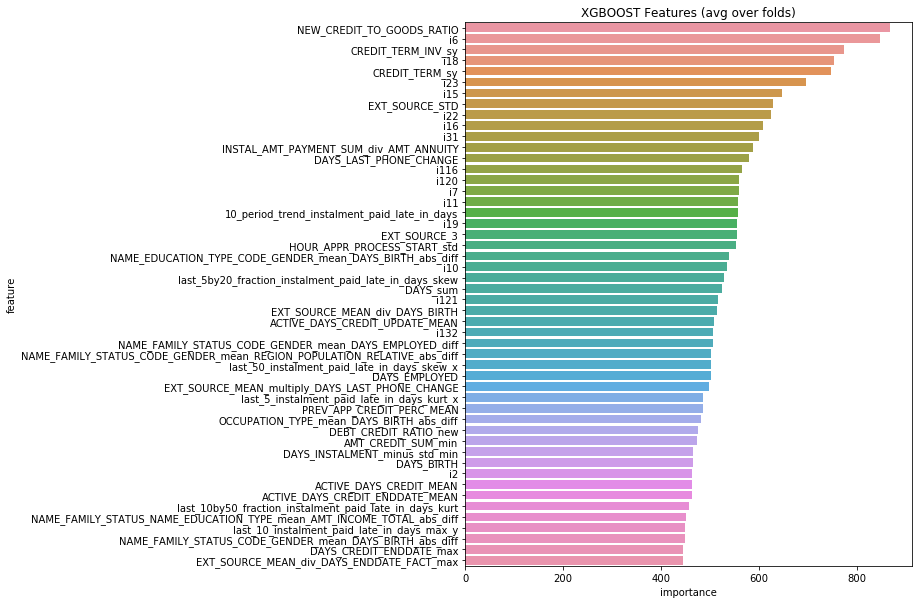

In [80]:
display_importances(fold_importance_df_xgb9)

In [77]:
importance_xgb9 = get_importances(fold_importance_df_xgb9)

In [81]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb9')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb9.to_csv(os.path.join(SaveDirPath,"importance_xgb9.csv"))
sub_xgb9.to_csv(os.path.join(SaveDirPath,"sub_xgb9.csv"), index=False)
subtmp_xgb9.to_csv(os.path.join(SaveDirPath,"oof_test_xgb9.csv"), index=False)
oof_train_xgb9 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb9})
oof_train_xgb9.to_csv(os.path.join(SaveDirPath,"oof_train_xgb9.csv"), index=False)

### 2.10 xgb_0803

In [27]:
SaveDirPath = os.path.join(ResultSaveDir,'xgb7')
importance_xgb7 = pd.read_csv(os.path.join(SaveDirPath,"importance_xgb7.csv"),index_col=0)
importance_xgb7.head()

,importance
feature,
NEW_CREDIT_TO_GOODS_RATIO,917
EXT_SOURCE_3,847
DAYS_BIRTH,820
EXT_SOURCE_MEAN,802
CREDIT_TERM_INV_sy,755


In [28]:
importance_cum = importance_xgb7.importance/importance_xgb7.importance.sum()
importance_cum = importance_cum.cumsum()
importance_cum.head()

feature
NEW_CREDIT_TO_GOODS_RATIO    0.005112
EXT_SOURCE_3                 0.009833
DAYS_BIRTH                   0.014404
EXT_SOURCE_MEAN              0.018875
CREDIT_TERM_INV_sy           0.023083
Name: importance, dtype: float64

In [30]:
features_keep = importance_cum[importance_cum<=0.98].index.tolist()
len(features_keep)

797

In [31]:
features = features_keep

In [32]:
stratified = True

In [33]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds_xgb10 = np.zeros(df_train.shape[0])
sub_preds_xgb10 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb10 = []
feature_importance_df_xgb10 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb10[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb10[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb10 = roc_auc_score(valid_y, oof_preds_xgb10[valid_idx])
    roc_score_list_xgb10.append(roc_curr_xgb10)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb10))
    
    importance_xgb10 = clf.get_fscore()
    fold_importance_df_xgb10 = pd.DataFrame(list(importance_xgb10.items()), columns=['feature','importance'])
    fold_importance_df_xgb10["fold"] = n_fold + 1
    feature_importance_df_xgb10 = pd.concat([feature_importance_df_xgb10, fold_importance_df_xgb10], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1360), test shape: (48744, 1360)
Num of Feature: 797
stratified...
[04:43:32] Allocated 420MB on [0] GeForce GTX 1080 Ti, 10324MB remaining.
[04:43:33] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10318MB remaining.
[04:43:33] Allocated 140MB on [0] GeForce GTX 1080 Ti, 10176MB remaining.
[04:43:33] Allocated 288MB on [0] GeForce GTX 1080 Ti, 9884MB remaining.
[0]	train-auc:0.689011	valid-auc:0.691171
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.750813	valid-auc:0.748026
[400]	train-auc:0.775613	valid-auc:0.767781
[600]	train-auc:0.791101	valid-auc:0.778914
[800]	train-auc:0.801038	valid-auc:0.784583
[1000]	train-auc:0.808444	valid-auc:0.788275
[1200]	train-auc:0.814779	valid-auc:0.790982
[1400]	train-auc:0.820162	valid-auc:0.792754
[1600]	train-auc:0.824955	valid-auc:0.794188
[1800]	train-auc:0.82922	valid-auc:0.795157
[2000]	train-a

[3200]	train-auc:0.855164	valid-auc:0.792232
[3400]	train-auc:0.858395	valid-auc:0.792506
[3600]	train-auc:0.861563	valid-auc:0.79268
[3800]	train-auc:0.864634	valid-auc:0.792839
[4000]	train-auc:0.867682	valid-auc:0.793062
[4200]	train-auc:0.870551	valid-auc:0.793223
[4400]	train-auc:0.873344	valid-auc:0.793323
[4600]	train-auc:0.876148	valid-auc:0.793484
[4800]	train-auc:0.878737	valid-auc:0.793632
[5000]	train-auc:0.881345	valid-auc:0.793815
[5200]	train-auc:0.883872	valid-auc:0.793841
[5400]	train-auc:0.886345	valid-auc:0.793926
[5600]	train-auc:0.888875	valid-auc:0.794007
[5800]	train-auc:0.891376	valid-auc:0.794021
[6000]	train-auc:0.893663	valid-auc:0.794095
[6200]	train-auc:0.896017	valid-auc:0.794107
Stopping. Best iteration:
[6062]	train-auc:0.894399	valid-auc:0.794134

[05:34:42] Allocated 239MB on [0] GeForce GTX 1080 Ti, 9637MB remaining.
Fold  5 AUC : 0.794134


In [34]:
np.mean(roc_score_list_xgb10)

0.7956152182405083

In [35]:
subtmp_xgb10,sub_xgb10 = subtest(sub_preds_xgb10)

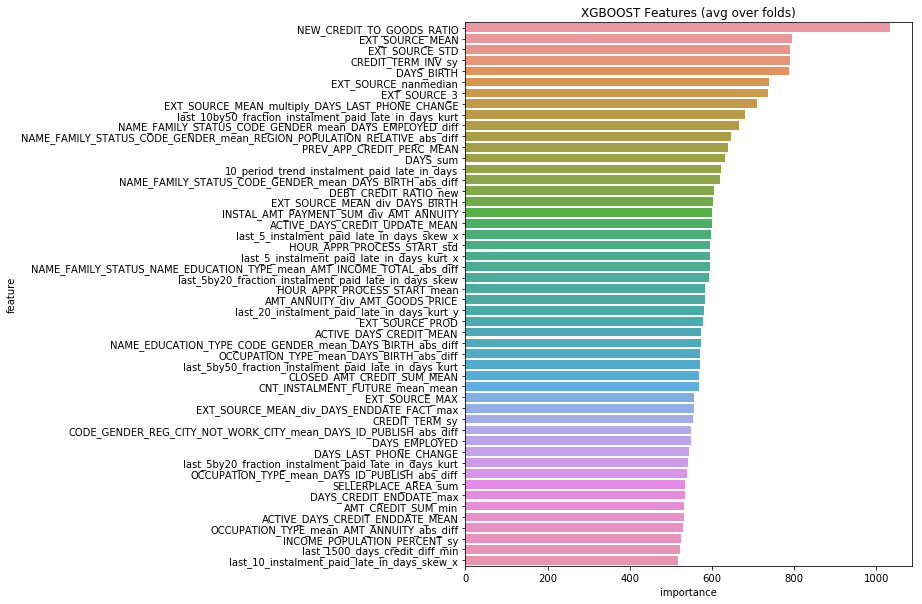

In [36]:
display_importances(fold_importance_df_xgb10)

In [38]:
importance_xgb10 = get_importances(fold_importance_df_xgb10)

In [39]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb10')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb10.to_csv(os.path.join(SaveDirPath,"importance_xgb10.csv"))
sub_xgb10.to_csv(os.path.join(SaveDirPath,"sub_xgb10.csv"), index=False)
subtmp_xgb10.to_csv(os.path.join(SaveDirPath,"oof_test_xgb10.csv"), index=False)
oof_train_xgb10 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb10})
oof_train_xgb10.to_csv(os.path.join(SaveDirPath,"oof_train_xgb10.csv"), index=False)

### 2.11 xgb_802

In [24]:
features.extend(feats50.columns.tolist())
len(features)

1407

In [25]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb11 = np.zeros(df_train.shape[0])
sub_preds_xgb11 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb11 = []
feature_importance_df_xgb11 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 40,
                      'max_depth': 8,
                      'subsample': 0.7,
                      'colsample_bytree': 0.5,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 200,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb11[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb11[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb11 = roc_auc_score(valid_y, oof_preds_xgb11[valid_idx])
    roc_score_list_xgb11.append(roc_curr_xgb11)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb11))
    
    importance_xgb11 = clf.get_fscore() 
    fold_importance_df_xgb11 = pd.DataFrame(list(importance_xgb11.items()), columns=['feature','importance'])
    fold_importance_df_xgb11["fold"] = n_fold + 1
    feature_importance_df_xgb11 = pd.concat([feature_importance_df_xgb11, fold_importance_df_xgb11], axis=0)
    del clf, train_x, train_y, valid_x, valid_y, data_train, data_valid, data_test
    gc.collect()

Starting XGBoost. Train shape: (307511, 1410), test shape: (48744, 1410)
Num of Feature: 1407
KFold...
[09:21:47] Allocated 742MB on [0] GeForce GTX 1080 Ti, 10003MB remaining.
[09:21:48] Allocated 7MB on [0] GeForce GTX 1080 Ti, 9997MB remaining.
[09:21:48] Allocated 249MB on [0] GeForce GTX 1080 Ti, 9747MB remaining.
[09:21:48] Allocated 509MB on [0] GeForce GTX 1080 Ti, 9233MB remaining.
[0]	train-auc:0.6278	valid-auc:0.624465
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.758693	valid-auc:0.750927
[400]	train-auc:0.779336	valid-auc:0.766849
[600]	train-auc:0.793744	valid-auc:0.776845
[800]	train-auc:0.803543	valid-auc:0.782347
[1000]	train-auc:0.810996	valid-auc:0.785666
[1200]	train-auc:0.817209	valid-auc:0.787856
[1400]	train-auc:0.822877	valid-auc:0.789488
[1600]	train-auc:0.827842	valid-auc:0.7907
[1800]	train-auc:0.832379	valid-auc:0.791624
[2000]	train-auc:0.8366

[2000]	train-auc:0.83659	valid-auc:0.79001
[2200]	train-auc:0.840609	valid-auc:0.790652
[2400]	train-auc:0.844458	valid-auc:0.791162
[2600]	train-auc:0.848163	valid-auc:0.791671
[2800]	train-auc:0.851818	valid-auc:0.792145
[3000]	train-auc:0.855222	valid-auc:0.792509
[3200]	train-auc:0.858663	valid-auc:0.792818
[3400]	train-auc:0.861974	valid-auc:0.793089
[3600]	train-auc:0.865215	valid-auc:0.793294
[3800]	train-auc:0.868324	valid-auc:0.793379
[4000]	train-auc:0.871328	valid-auc:0.793459
[4200]	train-auc:0.87417	valid-auc:0.793607
[4400]	train-auc:0.877076	valid-auc:0.793764
[4600]	train-auc:0.879854	valid-auc:0.793857
[4800]	train-auc:0.88257	valid-auc:0.793973
[5000]	train-auc:0.885253	valid-auc:0.794079
[5200]	train-auc:0.88795	valid-auc:0.794143
[5400]	train-auc:0.890528	valid-auc:0.794203
Stopping. Best iteration:
[5342]	train-auc:0.88977	valid-auc:0.79422

[10:48:53] Allocated 420MB on [0] GeForce GTX 1080 Ti, 8800MB remaining.
Fold  5 AUC : 0.794220


In [26]:
np.mean(roc_score_list_xgb11)

0.7962338814166805

In [27]:
subtmp_xgb11,sub_xgb11 = subtest(sub_preds_xgb11)

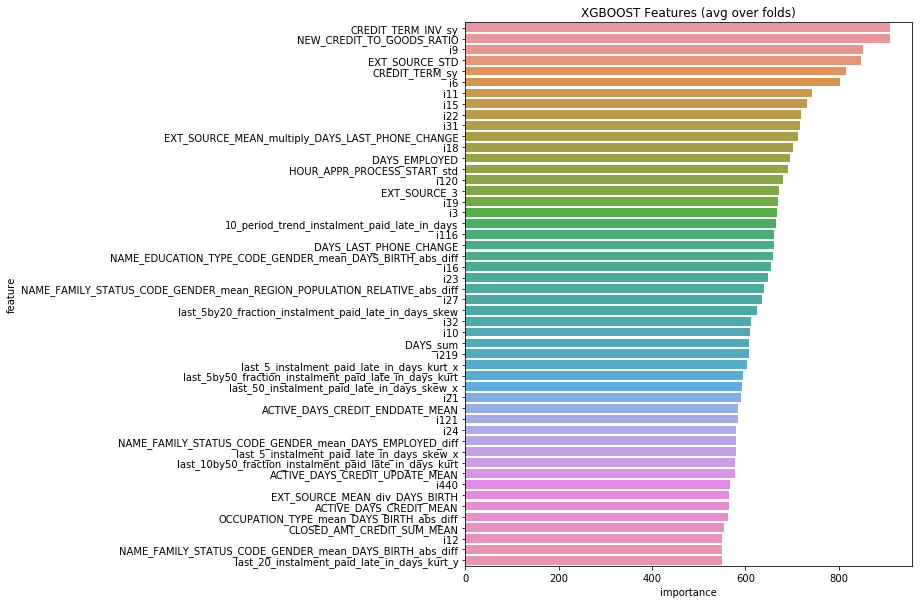

In [28]:
display_importances(fold_importance_df_xgb11)

In [29]:
importance_xgb11 = get_importances(fold_importance_df_xgb11)

In [30]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb11')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb11.to_csv(os.path.join(SaveDirPath,"importance_xgb11.csv"))
sub_xgb11.to_csv(os.path.join(SaveDirPath,"sub_xgb11.csv"), index=False)
subtmp_xgb11.to_csv(os.path.join(SaveDirPath,"oof_test_xgb11.csv"), index=False)
oof_train_xgb11 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb11})
oof_train_xgb11.to_csv(os.path.join(SaveDirPath,"oof_train_xgb11.csv"), index=False)

### 2.12 xgb_0802

In [29]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb11 = np.zeros(df_train.shape[0])
sub_preds_xgb11 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb11 = []
feature_importance_df_xgb11 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.02,
                      'max_leaves': 40,
                      'max_depth': 6,
                      'subsample': 0.8,
                      'colsample_bytree': 0.6,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 400,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb11[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb11[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb11 = roc_auc_score(valid_y, oof_preds_xgb11[valid_idx])
    roc_score_list_xgb11.append(roc_curr_xgb11)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb11))
    
    importance_xgb11 = clf.get_fscore() 
    fold_importance_df_xgb11 = pd.DataFrame(list(importance_xgb11.items()), columns=['feature','importance'])
    fold_importance_df_xgb11["fold"] = n_fold + 1
    feature_importance_df_xgb11 = pd.concat([feature_importance_df_xgb11, fold_importance_df_xgb11], axis=0)
    del clf, train_x, train_y, valid_x, valid_y, data_train, data_valid, data_test
    gc.collect()

Starting XGBoost. Train shape: (307511, 1410), test shape: (48744, 1410)
Num of Feature: 1407
KFold...
[11:30:44] Allocated 742MB on [0] GeForce GTX 1080 Ti, 10003MB remaining.
[11:30:44] Allocated 7MB on [0] GeForce GTX 1080 Ti, 9997MB remaining.
[11:30:44] Allocated 249MB on [0] GeForce GTX 1080 Ti, 9747MB remaining.
[11:30:44] Allocated 509MB on [0] GeForce GTX 1080 Ti, 9233MB remaining.
[0]	train-auc:0.62601	valid-auc:0.622999
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.775742	valid-auc:0.764846
[400]	train-auc:0.799218	valid-auc:0.780506
[600]	train-auc:0.812136	valid-auc:0.786096
[800]	train-auc:0.821946	valid-auc:0.789122
[1000]	train-auc:0.83001	valid-auc:0.790915
[1200]	train-auc:0.837065	valid-auc:0.791993
[1400]	train-auc:0.843579	valid-auc:0.792732
[1600]	train-auc:0.849646	valid-auc:0.793336
[1800]	train-auc:0.85534	valid-auc:0.793619
[2000]	train-auc:0.860

In [31]:
np.mean(roc_score_list_xgb11)

0.7956035429032482

In [32]:
subtmp_xgb11,sub_xgb11 = subtest(sub_preds_xgb11)

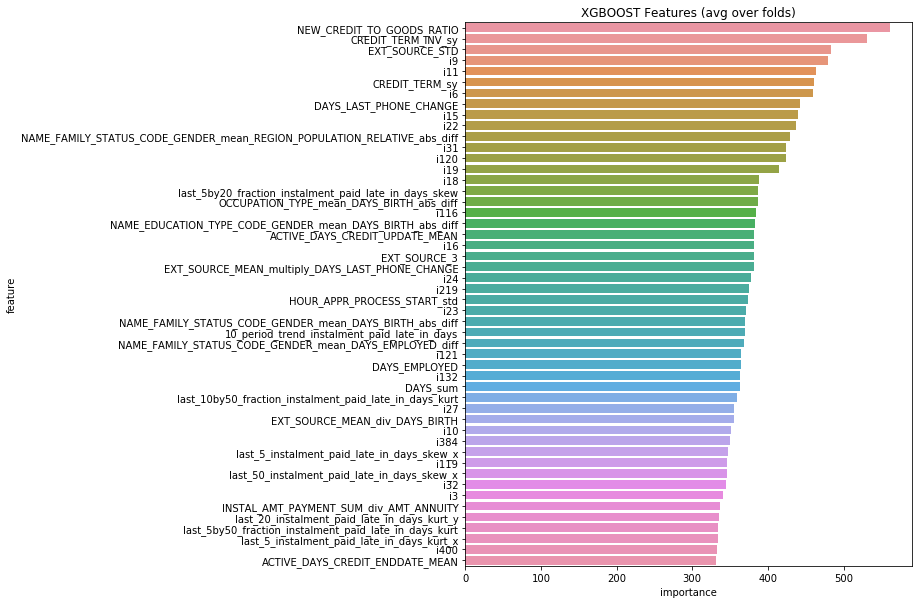

In [30]:
display_importances(fold_importance_df_xgb11)

In [33]:
importance_xgb11 = get_importances(fold_importance_df_xgb11)
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb12')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb11.to_csv(os.path.join(SaveDirPath,"importance_xgb12.csv"))
sub_xgb11.to_csv(os.path.join(SaveDirPath,"sub_xgb12.csv"), index=False)
subtmp_xgb11.to_csv(os.path.join(SaveDirPath,"oof_test_xgb12.csv"), index=False)
oof_train_xgb11 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb11})
oof_train_xgb11.to_csv(os.path.join(SaveDirPath,"oof_train_xgb12.csv"), index=False)

### 2.13 xgb_0802

In [34]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb11 = np.zeros(df_train.shape[0])
sub_preds_xgb11 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb11 = []
feature_importance_df_xgb11 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 40,
                      'max_depth': 6,
                      'subsample': 0.8,
                      'colsample_bytree': 0.65,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 420,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=100,
                     verbose_eval=200)
    
    oof_preds_xgb11[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb11[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb11 = roc_auc_score(valid_y, oof_preds_xgb11[valid_idx])
    roc_score_list_xgb11.append(roc_curr_xgb11)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb11))
    
    importance_xgb11 = clf.get_fscore() 
    fold_importance_df_xgb11 = pd.DataFrame(list(importance_xgb11.items()), columns=['feature','importance'])
    fold_importance_df_xgb11["fold"] = n_fold + 1
    feature_importance_df_xgb11 = pd.concat([feature_importance_df_xgb11, fold_importance_df_xgb11], axis=0)
    del clf, train_x, train_y, valid_x, valid_y, data_train, data_valid, data_test
    gc.collect()

Starting XGBoost. Train shape: (307511, 1410), test shape: (48744, 1410)
Num of Feature: 1407
KFold...
[12:27:37] Allocated 742MB on [0] GeForce GTX 1080 Ti, 10002MB remaining.
[12:27:37] Allocated 7MB on [0] GeForce GTX 1080 Ti, 9996MB remaining.
[12:27:37] Allocated 249MB on [0] GeForce GTX 1080 Ti, 9746MB remaining.
[12:27:37] Allocated 509MB on [0] GeForce GTX 1080 Ti, 9232MB remaining.
[0]	train-auc:0.626013	valid-auc:0.622999
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.753332	valid-auc:0.74636
[400]	train-auc:0.775224	valid-auc:0.7647
[600]	train-auc:0.789288	valid-auc:0.774832
[800]	train-auc:0.798846	valid-auc:0.78067
[1000]	train-auc:0.80593	valid-auc:0.78421
[1200]	train-auc:0.811885	valid-auc:0.786484
[1400]	train-auc:0.817035	valid-auc:0.788199
[1600]	train-auc:0.82164	valid-auc:0.789496
[1800]	train-auc:0.825864	valid-auc:0.790535
[2000]	train-auc:0.829743	

[4200]	train-auc:0.862433	valid-auc:0.792978
[4400]	train-auc:0.864993	valid-auc:0.793142
[4600]	train-auc:0.867488	valid-auc:0.79327
[4800]	train-auc:0.870023	valid-auc:0.793288
[5000]	train-auc:0.872364	valid-auc:0.793434
[5200]	train-auc:0.874692	valid-auc:0.793578
[5400]	train-auc:0.877048	valid-auc:0.793644
[5600]	train-auc:0.879332	valid-auc:0.793714
[5800]	train-auc:0.881514	valid-auc:0.793769
[6000]	train-auc:0.883692	valid-auc:0.79384
[6200]	train-auc:0.885808	valid-auc:0.793936
Stopping. Best iteration:
[6145]	train-auc:0.885249	valid-auc:0.793947

[13:45:32] Allocated 420MB on [0] GeForce GTX 1080 Ti, 8801MB remaining.
Fold  5 AUC : 0.793947


In [35]:
np.mean(roc_score_list_xgb11)

0.7957492266546498

In [36]:
subtmp_xgb13,sub_xgb13 = subtest(sub_preds_xgb11)

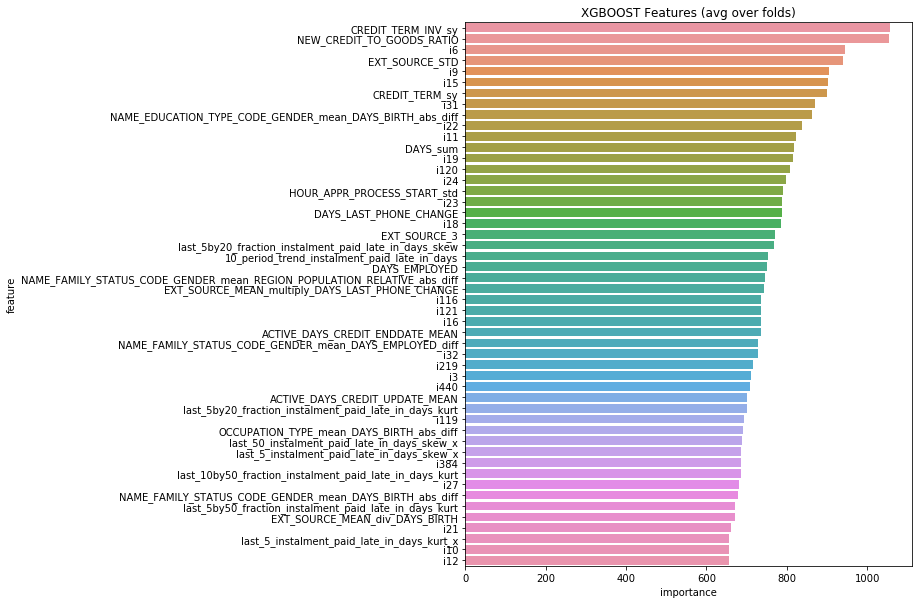

In [37]:
display_importances(fold_importance_df_xgb11)

In [38]:
importance_xgb13 = get_importances(fold_importance_df_xgb11)
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb13')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb13.to_csv(os.path.join(SaveDirPath,"importance_xgb13.csv"))
sub_xgb13.to_csv(os.path.join(SaveDirPath,"sub_xgb13.csv"), index=False)
subtmp_xgb13.to_csv(os.path.join(SaveDirPath,"oof_test_xgb13.csv"), index=False)
oof_train_xgb11 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb11})
oof_train_xgb11.to_csv(os.path.join(SaveDirPath,"oof_train_xgb13.csv"), index=False)

### 2.14 xgb_0802

In [73]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb14 = np.zeros(df_train.shape[0])
sub_preds_xgb14 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb14 = []
feature_importance_df_xgb14 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.01,
                      'max_leaves': 30,
                      'max_depth': 16,
                      'subsample': 0.7,
                      'colsample_bytree': 0.6,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb14[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb14[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb14 = roc_auc_score(valid_y, oof_preds_xgb14[valid_idx])
    roc_score_list_xgb14.append(roc_curr_xgb14)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb14))
    
    importance_xgb14 = clf.get_fscore()
    fold_importance_df_xgb14 = pd.DataFrame(list(importance_xgb14.items()), columns=['feature','importance'])
    fold_importance_df_xgb14["fold"] = n_fold + 1
    feature_importance_df_xgb14 = pd.concat([feature_importance_df_xgb14, fold_importance_df_xgb14], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 1396), test shape: (48744, 1396)
Num of Feature: 1394
KFold...
[04:32:57] Allocated 735MB on [0] GeForce GTX 1080 Ti, 10011MB remaining.
[04:32:57] Allocated 7MB on [0] GeForce GTX 1080 Ti, 10005MB remaining.
[04:32:57] Allocated 179MB on [0] GeForce GTX 1080 Ti, 9825MB remaining.
[04:32:58] Allocated 502MB on [0] GeForce GTX 1080 Ti, 9317MB remaining.
[0]	train-auc:0.684285	valid-auc:0.68857
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.752408	valid-auc:0.744613
[400]	train-auc:0.776596	valid-auc:0.764071
[600]	train-auc:0.792038	valid-auc:0.775438
[800]	train-auc:0.801706	valid-auc:0.781211
[1000]	train-auc:0.809184	valid-auc:0.78505
[1200]	train-auc:0.815348	valid-auc:0.78738
[1400]	train-auc:0.820751	valid-auc:0.789155
[1600]	train-auc:0.825596	valid-auc:0.790415
[1800]	train-auc:0.830044	valid-auc:0.7914
[2000]	train-auc:0.8340

[1600]	train-auc:0.826135	valid-auc:0.787939
[1800]	train-auc:0.830595	valid-auc:0.78914
[2000]	train-auc:0.834546	valid-auc:0.790049
[2200]	train-auc:0.83844	valid-auc:0.790785
[2400]	train-auc:0.84204	valid-auc:0.79128
[2600]	train-auc:0.845693	valid-auc:0.791863
[2800]	train-auc:0.849176	valid-auc:0.79231
[3000]	train-auc:0.852455	valid-auc:0.792631
[3200]	train-auc:0.855704	valid-auc:0.792871
[3400]	train-auc:0.858912	valid-auc:0.793209
[3600]	train-auc:0.861948	valid-auc:0.793511
[3800]	train-auc:0.865023	valid-auc:0.793755
[4000]	train-auc:0.867891	valid-auc:0.793922
[4200]	train-auc:0.870725	valid-auc:0.79406
[4400]	train-auc:0.873599	valid-auc:0.794212
[4600]	train-auc:0.876269	valid-auc:0.794382
[4800]	train-auc:0.879005	valid-auc:0.794487
[5000]	train-auc:0.881599	valid-auc:0.794568
[5200]	train-auc:0.884187	valid-auc:0.794641
[5400]	train-auc:0.886765	valid-auc:0.794669
Stopping. Best iteration:
[5320]	train-auc:0.885746	valid-auc:0.794674

[06:13:34] Allocated 415MB on [0] 

In [74]:
np.mean(roc_score_list_xgb14)

0.7961287879760193

In [75]:
subtmp_xgb14,sub_xgb14 = subtest(sub_preds_xgb14)

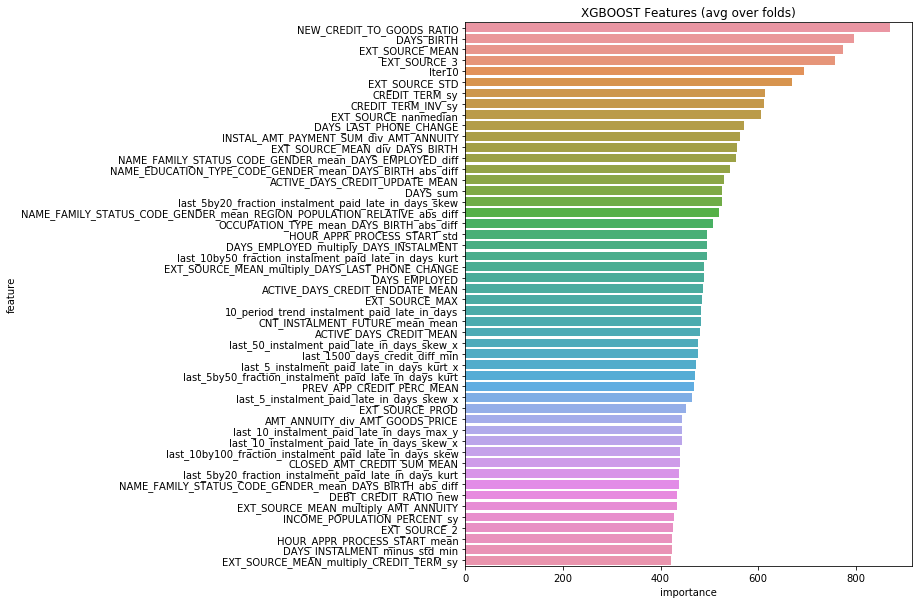

In [76]:
display_importances(fold_importance_df_xgb14)

In [77]:
importance_xgb14= get_importances(fold_importance_df_xgb14)
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb14')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb14.to_csv(os.path.join(SaveDirPath,"importance_xgb14.csv"))
sub_xgb14.to_csv(os.path.join(SaveDirPath,"sub_xgb14.csv"), index=False)
subtmp_xgb14.to_csv(os.path.join(SaveDirPath,"oof_test_xgb14.csv"), index=False)
oof_train_xgb14 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb14})
oof_train_xgb14.to_csv(os.path.join(SaveDirPath,"oof_train_xgb14.csv"), index=False)

### 2.15 xgb_0802

In [59]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb15 = np.zeros(df_train.shape[0])
sub_preds_xgb15 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb15 = []
feature_importance_df_xgb15 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.015,
                      'max_leaves': 35,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 200,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb15[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb15[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb15 = roc_auc_score(valid_y, oof_preds_xgb15[valid_idx])
    roc_score_list_xgb15.append(roc_curr_xgb15)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb15))
    
    importance_xgb15 = clf.get_fscore()
    fold_importance_df_xgb15 = pd.DataFrame(list(importance_xgb15.items()), columns=['feature','importance'])
    fold_importance_df_xgb15["fold"] = n_fold + 1
    feature_importance_df_xgb15 = pd.concat([feature_importance_df_xgb15, fold_importance_df_xgb15], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 2625), test shape: (48744, 2625)
Num of Feature: 2622
KFold...
[22:08:09] Allocated 1459MB on [0] GeForce GTX 1080 Ti, 6459MB remaining.
[22:08:10] Allocated 8MB on [0] GeForce GTX 1080 Ti, 6451MB remaining.
[22:08:10] Allocated 458MB on [0] GeForce GTX 1080 Ti, 5991MB remaining.
[22:08:10] Allocated 953MB on [0] GeForce GTX 1080 Ti, 5037MB remaining.
[0]	train-auc:0.654714	valid-auc:0.648155
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.771123	valid-auc:0.760928
[400]	train-auc:0.795595	valid-auc:0.778155
[600]	train-auc:0.809348	valid-auc:0.785402
[800]	train-auc:0.819258	valid-auc:0.789153
[1000]	train-auc:0.827461	valid-auc:0.791355
[1200]	train-auc:0.834399	valid-auc:0.792622
[1400]	train-auc:0.840805	valid-auc:0.793501
[1600]	train-auc:0.846704	valid-auc:0.794185
[1800]	train-auc:0.852137	valid-auc:0.794719
[2000]	train-auc:0.

In [61]:
print(np.mean(roc_score_list_xgb15))
print(np.std(roc_score_list_xgb15))

0.796723576431666
0.002475547728752634


In [62]:
subtmp_xgb15,sub_xgb15 = subtest(sub_preds_xgb15)

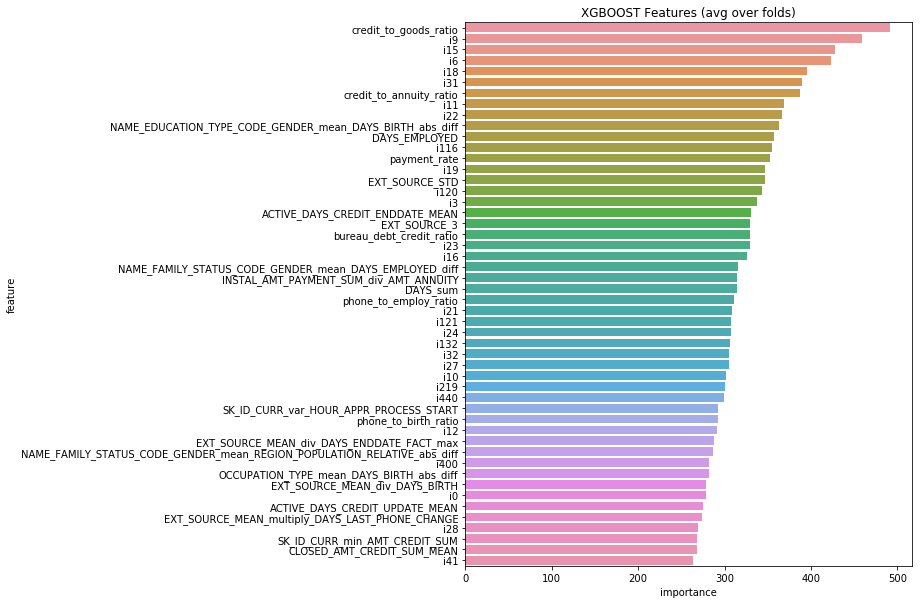

In [63]:
display_importances(fold_importance_df_xgb15)

In [64]:
importance_xgb15= get_importances(fold_importance_df_xgb15)
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb15')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb15.to_csv(os.path.join(SaveDirPath,"importance_xgb15.csv"))
sub_xgb15.to_csv(os.path.join(SaveDirPath,"sub_xgb15.csv"), index=False)
subtmp_xgb15.to_csv(os.path.join(SaveDirPath,"oof_test_xgb15.csv"), index=False)
oof_train_xgb15 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb15})
oof_train_xgb15.to_csv(os.path.join(SaveDirPath,"oof_train_xgb15.csv"), index=False)

### 2.16 xgb

In [21]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb16 = np.zeros(df_train.shape[0])
sub_preds_xgb16 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb16 = []
feature_importance_df_xgb16 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.02,
                      'max_leaves': 35,
                      'max_depth': 16,
                      'subsample': 0.8,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 1,
                      'min_child_weight': 1,
                      'lambda': 100,
                      'alpha':0.0,
                      'nthread':-1,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb16[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb16[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb16 = roc_auc_score(valid_y, oof_preds_xgb16[valid_idx])
    roc_score_list_xgb16.append(roc_curr_xgb16)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb16))
    
    importance_xgb16 = clf.get_fscore()
    fold_importance_df_xgb16 = pd.DataFrame(list(importance_xgb16.items()), columns=['feature','importance'])
    fold_importance_df_xgb16["fold"] = n_fold + 1
    feature_importance_df_xgb16 = pd.concat([feature_importance_df_xgb16, fold_importance_df_xgb16], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 605), test shape: (48744, 605)
Num of Feature: 598
KFold...
[04:05:07] Allocated 315MB on [0] GeForce GTX 1080 Ti, 9682MB remaining.
[04:05:07] Allocated 7MB on [0] GeForce GTX 1080 Ti, 9676MB remaining.
[04:05:07] Allocated 142MB on [0] GeForce GTX 1080 Ti, 9532MB remaining.
[04:05:07] Allocated 243MB on [0] GeForce GTX 1080 Ti, 9286MB remaining.
[0]	train-auc:0.694808	valid-auc:0.695369
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[200]	train-auc:0.783142	valid-auc:0.768937
[400]	train-auc:0.808161	valid-auc:0.783738
[600]	train-auc:0.822227	valid-auc:0.789081
[800]	train-auc:0.833272	valid-auc:0.791829
[1000]	train-auc:0.842425	valid-auc:0.793117
[1200]	train-auc:0.85062	valid-auc:0.794226
[1400]	train-auc:0.858321	valid-auc:0.794835
[1600]	train-auc:0.86553	valid-auc:0.795226
[1800]	train-auc:0.872341	valid-auc:0.795561
[2000]	train-auc:0.87895	

In [22]:
print(np.mean(roc_score_list_xgb16))
print(np.std(roc_score_list_xgb16))

0.796313749335939
0.0024256338742206104


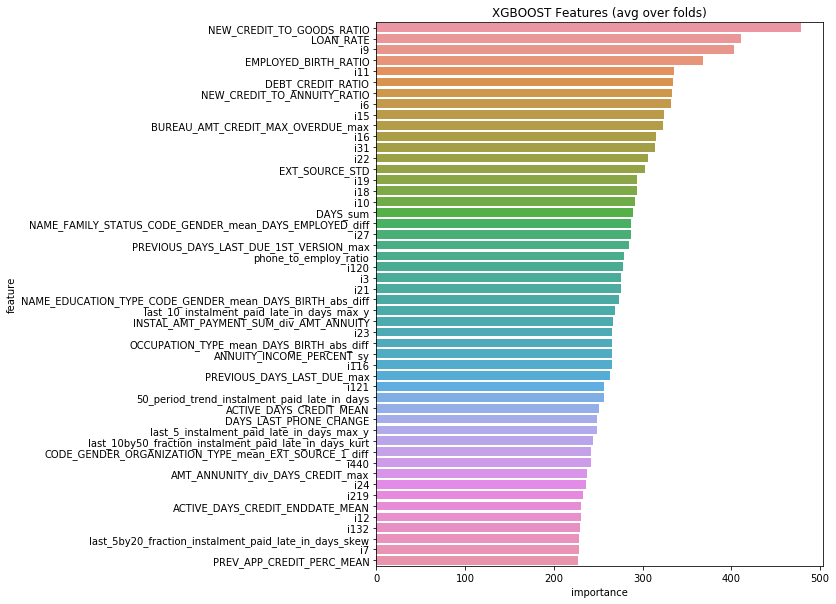

In [23]:
display_importances(fold_importance_df_xgb16)

In [24]:
subtmp_xgb16,sub_xgb16 = subtest(sub_preds_xgb16)
importance_xgb16= get_importances(fold_importance_df_xgb16)
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'xgb16')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance_xgb16.to_csv(os.path.join(SaveDirPath,"importance_xgb16.csv"))
sub_xgb16.to_csv(os.path.join(SaveDirPath,"sub_xgb16.csv"), index=False)
subtmp_xgb16.to_csv(os.path.join(SaveDirPath,"oof_test_xgb16.csv"), index=False)
oof_train_xgb16 = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds_xgb16})
oof_train_xgb16.to_csv(os.path.join(SaveDirPath,"oof_train_xgb16.csv"), index=False)

### 2.17 xgb

In [17]:
# Divide in training/validation and test data
print("Starting XGBoost. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    print('stratified...')
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    print('KFold...')
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds_xgb17 = np.zeros(df_train.shape[0])
sub_preds_xgb17 = np.zeros([df_test.shape[0],num_folds])
roc_score_list_xgb17 = []
feature_importance_df_xgb17 = pd.DataFrame()
     
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'booster': 'gbtree', # gpu cpu
                      #'tree_method':'gpu_hist',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'eta': 0.02,
                      'max_leaves': 35,
                      'max_depth': 8,
                      'subsample': 0.8,
                      'colsample_bytree': 0.8,
                      'colsample_bylevel': 1,
                      'min_child_weight': 4,
                      'lambda': 300,
                      'alpha':0.0,
                      'nthread':8,
                      #'seed':27,
                      'scale_pos_weight': 1}
    data_train = xgb.DMatrix(train_x,label=train_y)
    data_valid = xgb.DMatrix(valid_x,label=valid_y)
    data_test = xgb.DMatrix(df_test[features],label=None)
    clf = xgb.train( params=model_config,
                     dtrain=data_train,
                     evals=[(data_train, 'train'), (data_valid, 'valid')],
                     num_boost_round=10000,
                     early_stopping_rounds=200,
                     verbose_eval=200)
    
    oof_preds_xgb17[valid_idx] = clf.predict(data_valid,ntree_limit=clf.best_ntree_limit)
    sub_preds_xgb17[:,n_fold]= clf.predict(data_test,ntree_limit=clf.best_ntree_limit)
    roc_curr_xgb17 = roc_auc_score(valid_y, oof_preds_xgb17[valid_idx])
    roc_score_list_xgb17.append(roc_curr_xgb17)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr_xgb17))
    
    importance_xgb17 = clf.get_fscore()
    fold_importance_df_xgb17 = pd.DataFrame(list(importance_xgb17.items()), columns=['feature','importance'])
    fold_importance_df_xgb17["fold"] = n_fold + 1
    feature_importance_df_xgb17 = pd.concat([feature_importance_df_xgb17, fold_importance_df_xgb17], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting XGBoost. Train shape: (307511, 142), test shape: (0, 142)
Num of Feature: 140
KFold...
[0]	train-auc:0.75695	valid-auc:0.752363
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[200]	train-auc:0.808385	valid-auc:0.798896


KeyboardInterrupt: 